Top 100 Billboard Analysis by Betta Kalisa (s174273), Mikkel Gallus Thang (s174278) and Sebastian Tønne Kotewitz (s174270)

# 1. Motivation

## Introduction

Music plays a part in the daily lives of almost everyone and is one of the most widely used media of entertainment. On average an individual listen to music up to 18 hours a week which corresponds to 52 minutes daily. Music generally gathers inspiration from current trends and topics, which means that it can be quite significant in determining a popular trend in a specific period. In this project we look at the most popular songs thought history (From 1963) and analyze period defining tendencies. What we want to investigate is whether we can observe a generally decrease in sentimental value and an increase in the use of strong language as well as determine whether this is a general trend or if it’s based on isolated events. 

## Dataset

For our dataset, we knew that we wanted to look at musical hits. To limit our data to a manageable size, we have chosen to limit our dataset to top songs over the years. This way we limit the amount of data to a smaller size, while still choosing data which represents the time period. We chose 'The Billboard Hot 100' published by The Billboard Magazine as our song dataset, and although this list focuses on popularity in USA, we felt it represented global musical interest well enough for our purpose.  
This dataset was not enough, however, as it only included information about *song title*, *artist* and *rank*. We knew that we would need the lyrics of the songs as well, so we had to find an additional source of data.  
We turned to the Genius website by Genius Media Group inc and found that they had an API which allowed us to query their database by song title and artist. This second dataset allowed us to make sure our formatting of primary and featuring artists were consistent, as well as allowing us to get the lyrics of the song.  
It is the combination of these two dataset which allows us to analyze musical trends ranging from 1965 to today.  

## Goals

Our project aims to find whether or not there is a negative trend in current music concerning negativity. We want to find out if the general trend of sentimental values in lyrics have been negative, and whether or not the negativity is contained in smaller communities or not. In short, we want to answer the following questions:

- Is there a general negative trend when it comes to the average sentimental values of lyrics over the years?
- Can we, via communities, find local interconnected groups of artists that line up with our understanding of genres and collaborating artists?
- Is there a contained lower sentimental average within recent communities?

# 2. Basic stats

This section aims to give a better understanding of the used dataset. It has been split into two parts: **Network creation** and **General statistics**.

The first part explains different sources of data, how and why they have been used in hope of achieving our goals, and wether or not the final outcome in form of our generated network has been succesfull or not.

The second part investigates the created network by different statistical measures and comparisons.

## Network creation

This subsection first discovers the necessities to retrieve the most popular songs in modern music industry from Billboard. Secondly, it explains how to retrieve belonging information and lyrics to these songs using Genius. Third and finally, the creation of the network and reasoning behind is explained as well.

### Billboard Top 100 song retrieval

The hot 100 chart, also referred to as the Billboard Top 100, doesn't have a working api to work with. Therefore, the data from this site has to be fecthed manually from their normal url and scraped for information afterwards.

As the chart consist information regarding top singles and artists for every week and year since its beginning, it was decided that the data eventually should be saved as a json object (directly appliable as a python dictionary) with the following data structure:

billboard = {

    'year': {
        'week': {
            'rank': {
                'title': 'song_title',
                'artist': 'artist_name' 
            }
        }
    }
}

All necesarry imports to run this project are listed below:

In [556]:
import networkx as nx
import pickle
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests, datetime, time, re, json, io
import numpy as np
import community
from wordcloud import WordCloud
import math
import nltk, pprint, os
from nltk import word_tokenize
from nltk.corpus import stopwords
import urllib
from requests.exceptions import HTTPError, Timeout
import seaborn as sns
sns.set()

The function **downloadBillboardWeek** returns a dictionary for an entire week of the hot 100 chart. This means 100 different ranks, all including title and combined artists (all featuring). As Billboard's server limits the amount of request per minute to prevent overheat, different error codes needs to be handled and the application often needs to sleep for a few seconds, before it is allowed to continue its data download.

All downloaded data is formatted using the library ***BeautifulSoup***, which lets you acces sections on the page by html tags. All list elements related to a ranked song on the chart is scraped and saved into the decribed dictionary.

In [ ]:
# Open session
s = requests.Session()

def downloadBillboardWeek(date):
    
    # Construct query with date
    query = "https://www.billboard.com/charts/hot-100/" + date
    # Retrieve data
    req = s.get(query)
    # Handle possible errors
    if req.status_code == 429:
        print("429: + " + date)
        # 429 Client Error: Too Many Requests for url
        print("Retrying after: " + str(req.headers["Retry-After"]))
        time.sleep(int(req.headers["Retry-After"]))
        # Try to download again after suggested time
        return downloadBillboardWeek(date)
    elif req.status_code == 503:
        print("503: + " + date)
        time.sleep(1)
        return downloadBillboardWeek(date)
    else:
        # Raise if other type
        req.raise_for_status()
    # Extract html
    html = req.text
    # Parse as beautiful soup
    soup = BeautifulSoup(html, 'html.parser')
    # Iterate through all songs and collect info
    billboardWeek = {}

    songs = soup.find_all('li', class_='chart-list__element')
    for song in songs:
        # Extract song rank
        rank_raw = song.find('span', class_='chart-element__rank__number')
        rank = int(rank_raw.text.strip())
        # Extract song title
        title_raw = song.find('span', class_='chart-element__information__song')
        title = title_raw.text.strip()
        # Extract song artist
        artist_raw = song.find('span', class_='chart-element__information__artist')
        artist = artist_raw.text.strip()
        # Add title and artist to week
        billboardWeek[rank] = {}
        billboardWeek[rank]['title'] = title
        billboardWeek[rank]['artist'] = artist
    
    return billboardWeek

The function **downloadBillboard** iterates all weeks between two given dates. For each week **downloadBillboardWeek** is called, and the returned dictionary is stored in appropiate weeks of the master dictionary.

**Note**: Billboard.com contains data for the Hot 100 chart all the way back to August 4. 1958. In this project however, data is only fecthed from 1965 and onwards. This is due to Billboard changing their calender structure multiple times over the first 8 years, resulting in wrongly categorized data and multiple duplicates when using Pyhton's ***Datetime*** library. The first and last week of a year will over these years interchangebly refer to the former or latter year, with no strict pattern. Hence, it was ultimately decided to leave out these years.

In [ ]:
def downloadBillboard(startDate, endDate):
    # Format dates
    dateFormat = "%Y-%m-%d"
    startDate = datetime.datetime.strptime(startDate, dateFormat)
    endDate = datetime.datetime.strptime(endDate, dateFormat)

    tempDate = startDate
    tempYear = tempDate.year
    while tempDate < endDate:
        # Initialize billboard and year
        billboard = {}
        billboard[tempYear] = {}
        print("Downloading year: %s" %tempYear)
        while tempDate.year == tempYear and tempDate < endDate:
            week = tempDate.strftime("%V")
            print("Week: %s" %week)
            # Initialize weeknumber and download week data
            billboard[tempDate.year][week] = downloadBillboardWeek(tempDate.strftime(dateFormat))
            # Move to next week
            tempDate += datetime.timedelta(days=7)
        # Save year to file
        path = "./billboard/" + str(tempYear) + ".txt"
        with open(path, "w") as file:
            json.dump(billboard, file, sort_keys=True, indent=4)
        print("Year saved: %s" %tempYear)
        # Increment year
        tempYear = tempDate.year

# DOWNLOAD DATA
downloadBillboard('1965-01-09', '2020-11-16')

Untill 1997 it was common practise on the billboard charts to include a movie's title on a song’s title, if the song was published as part of the movie's soundtrack. This became a problem when the song's information later had to be fecthed from Genius' api, as the search engine in many of such cases wasn't intelligent enough to find the correlated song (Mainly when "\\\\" symbols and "Theme" keywords interfered).

Unfortunately, this was first discovered after the retrieval of all the songs from the Billboard Top 100. Therefore, the functions below was written to filter through the mentioned occurances and remove such references, so that more nodes eventually would be added to the network.

In [ ]:
def removeMovieRefsFromTitles(year):
    # Load year file
    path = "./billboard/" + str(year) + ".txt"
    billboard = eval(open(path).read())
    # Iterate through titles each week
    for w in billboard[str(year)].items():
        for r in w[1].items():
            # Remove potential movie reference styles
            title = r[1]['title'].split(' (From \\')
            if len(title) == 1:
                title = r[1]['title'].split(' (Theme From')
            if len(title) == 1:
                title = r[1]['title'].split(' (Love Theme From')
            # Update dict
            billboard[str(year)][w[0]][r[0]]['title'] = title[0]
    # Save updated dict
    with open(path, "w") as file:
        json.dump(billboard, file, sort_keys=True, indent=4)

def removeMovieRefsFromTitlesSpecific(startYear, endYear):
    for i in range(startYear,endYear):
        print("Removing movire references from year: {}" .format(i))
        removeMovieRefsFromTitles(i)

# FILTER THROUGH ALL YEARS AND REMOVE BAD MOVIE REFS
removeMovieRefsFromTitlesSpecific(1965, 1998)

### Genius song information and lyrics retrieval
To help us generate the network we needed a way of retreiving data from the *Genius API*. We created a python class, **LyricsGenius**, with the function: **fullInfo**.  
The first function, **fullInfo**, takes an artist name, the song title and the year, and returns a list of primary artists, a list of featured artists and the lyrics of the song. The function searches the *Genius API* using the song title and artist passed, the result contains the exact *id* of the song result. Another API request is required to find the full information of the song. This result contains information about primary artist(s), featured artist, release date and a URL to a webpage containing the lyrics. If the release year of the result comes after the year passed to the function, nothing is returned. If no results are found at all, nothing is returned.    
To get the lyrics, the web page of the URL in the returned result is scraped for lyrics. This code is based on code from the [Genius API python project](https://github.com/johnwmillr/LyricsGenius/blob/master/lyricsgenius/genius.py).  
Calling the API many times takes a long time, and html scraping can sometimes cause the server to respond with 429 or 503, effectively locking us out for a period of time. We would need a method of limiting API calls in the network generation process if we wanted to finish the network in a reasonable time span.  
Below is the code of our **LyricsGenius** class:

In [ ]:
class LyricsGenius():
    APIRoot = 'https://api.genius.com/'

    def __init__(self, access_token=None):
        self._session = requests.Session()
        self.access_token = access_token
        self.access_token = 'Bearer ' + self.access_token if self.access_token else None
        self.authorizationHeader = {'authorization': self.access_token}

    def _makeRequest_(self, path, params=None, web=False, **kwargs):
        if(not web):
            uri = self.APIRoot
            header = self.authorizationHeader
        else:
            uri = ""
            header = None
        uri = uri + path

        params = params if params else {}
        response = None
        sleep = 0.2
        response = self._session.request(
                'GET', uri, params=params, headers=header, **kwargs)
        if response.status_code == 429:
            time.sleep(int(response.headers["Retry-After"]))
            # Try to download again after suggested time
            return self._makeRequest_(path, params=params, web=web, kwargs=kwargs)
        elif response.status_code == 503:
            time.sleep(1)
            self._makeRequest_(path, params=params, web=web, kwargs=kwargs)
        else:
            # Raise if other type
            response.raise_for_status()
        time.sleep(sleep)

        if(web):
            return response.text
        elif response.status_code == 200:
            res = response.json()
            return res.get('response', res)
        else:
            return response.status

    def lyrics(self, songUrl):
        # Get the song lyrics by scraping song url
        div = None
        try:
            html = BeautifulSoup(
                self._makeRequest_(songUrl, web=True).replace('<br/>', '\n'),
                "html.parser"
            )
        except HTTPError as e:
            print(e)
            return ""
        div = html.find("div", class_=re.compile("^lyrics$|Lyrics__Root"))
        if div is None:
            div = html.find("div", class_=re.compile("LyricsPlaceholder__Container"))
            if div is None:
                print("dumping html")
                f = open("hallo.txt", "w", encoding='utf-8')
                f.write(str(html))
                f.close()
                return "Error with song url: {}".format(songUrl)
            else:
                return ""
        lyrics = div.get_text()

        lyrics = re.sub(r'(\[.*?\])*', '', lyrics)
        lyrics = re.sub('\n{2}', '\n', lyrics)

        return lyrics

    def _cleanString_(self, s):
        return s.strip().replace('\u200b', '').replace('\u200c', '')

    def _checkRelease_(self, song, year):
        release = song['release_date_for_display'] or None
        if(release is None):
            return False
        releaseYear = re.findall(r'\d{4}',release)
        if(len(releaseYear)==0):
            return False
        if (int(releaseYear[0]) > int(year)):
            return False
        else:
            return True

    def fullInfo(self, title, artist, year):
        artist = urllib.parse.quote(artist)
        title = urllib.parse.quote(title)
        path = "search?q=" + title + " " + artist
        searchResponse = self._makeRequest_(path)
        hits = searchResponse['hits']
        hitResults = [hit['result'] for hit in hits if hit['type'] == "song"]
        songIds = [song['id'] for song in hitResults]
        songUrls = [song['url'] for song in hitResults]
        if(len(songIds) == 0):
            return ([], [], "")
        
        songId = songIds[0]
        path = "songs/" + str(songId)
        songResponse = self._makeRequest_(path)
        song = songResponse['song']

        if(self._checkRelease_(song, year) == False):
            return([],[],"")

        lyrics = ""
        if(songUrls[0] is not None):
            lyrics = self.lyrics(songUrls[0])

        primaryArtists = re.split('&', song['primary_artist']['name'])
        primaryArtists = [artist.strip() for artist in primaryArtists]
        featuringArtists = song['featured_artists']
        featuringArtists = [artist['name'].strip()
                            for artist in featuringArtists]
        return([self._cleanString_(p) for p in primaryArtists], [self._cleanString_(f) for f in featuringArtists], lyrics)


### Generation of network
Our **Network Constructor** would go through the dictionary files from the **downloadBillboard** function and create a directed network. The constructor would take the song title and artist name and search the *Genius API* for results, the year, week and placement of the hit is also used in the next steps.  
The **Network Constructor** looks up the primary artist(s), featured artist, lyrics and year using the **fullInfo** function of the **LyricsGenius** class. The resulting lists of primary artists and featured artists is applied to the network in the following manner:  
- For each primary artist, create a node if it does not already exist
    - Add the song including lyrics if it does not already exist on the node
        - Add the placement of the song on the Top 100 Billboard as a dictionary {year, week, placement} to the song placement field
- For each featured artist, create a node if it does not already exist
    - Create an edge going from each featured artist to each primary artist with the song title as label

This way, every primary artist (which is mostly just one) will have the song including lyrics and all placement data on their nodes, and every featured artist will have links connecting the featured artists to the primary artists.  
To limit the amount of API calls, and to enable the possibility for all of us to run and construct different parts of the network at the same time, we implemented two external 'memory' files. The results of **fullInfo** are saved in the 'songMem' memory file as a dictionary pairing input and output. Likewise, the lyrics scraped from the html web pages are saved in the 'lyricsMem' memory file. The network constructor always attempts to find results in these files before fetching the data via the **LyricsGenius** class. The results from the **LyricsGenius** class are saved to the external memory files after every API call. This ensured we could quickly get back to where we were if the program should quit unexpectedly, or we simply didn't have time at the moment to run it anymore. This also gave us the possibility of splitting the network construction in three and running it on each of our home networks in parallel, where we could combine our memory files afterwards to quickly construct the network on one machine.  
We later added sentimental values to every song based on the lyrics. This is further expanded upon in a later chapter.  
After fully constructing the network with two complete memory files, the resulting network ended up taking 42.6 MB in gpickle format.  

Below is the code of our **Network Constructor** class:

In [ ]:
import networkx as nx
import re
import json
import pathlib
from lyricsGenius import LyricsGenius


class NetworkConstructor():

    def __init__(self, billboardMap, access_token=None, networkPath=None, songMemPath=None, lyricsMemPath=None):
        loadNet = pathlib.Path(networkPath)
        if(not loadNet.exists() and networkPath is not None):
            self.__network = nx.MultiDiGraph()
            nx.write_gpickle(self.__network, networkPath)

        loadMem = pathlib.Path(songMemPath)
        if(not loadMem.exists() and songMemPath is not None):
            f = open(songMemPath, 'a')
            f.write("{}")
            f.close()

        loadLyricsMem = pathlib.Path(lyricsMemPath)
        if(not loadLyricsMem.exists() and lyricsMemPath is not None):
            f = open(lyricsMemPath, 'a')
            f.write("{}")
            f.close()

        self.__network = nx.MultiDiGraph() if networkPath is None else nx.read_gpickle(networkPath)
        self.__songMem = {}
        self.__lyricsMem = {}
        if(songMemPath is not None):
            with open(songMemPath) as jsonFile:
                self.__songMem = json.load(jsonFile)
        self.__lyricsMemPath = lyricsMemPath
        if(self.__lyricsMemPath is not None):
            with open(self.__lyricsMemPath) as jsonFile:
                self.__lyricsMem = json.load(jsonFile)

        self.__lyricsGenius = LyricsGenius(access_token=access_token)
        for year in billboardMap.keys():
            for week in billboardMap[year].keys():
                for (rank, data) in billboardMap[year][week].items():
                    print("Processing year: {year}    week: {week}    rank: {rank}".format(
                        year=year, week=week, rank=rank))
                    artist = re.split(
                        'featuring|ft.|feat.|feat|&|and', data['artist'].lower())[0]
                    title = data['title']
                    if(str((title, artist)) not in self.__songMem):
                        (primary, featuring, lyrics) = self.__lyricsGenius.fullInfo(title, artist, year)
                        self.__songMem[str((title, artist))] = (primary, featuring)
                        self.__lyricsMem[str((title, artist))] = lyrics
                        # Write songMem to path
                        if(songMemPath is not None):
                            f = open(songMemPath, 'w')
                            json.dump(self.__songMem, f, indent=4)
                            f.close()
                        # Write lyricsMem to path
                        if(lyricsMemPath is not None):
                            f = open(lyricsMemPath, 'w')
                            json.dump(self.__lyricsMem, f, indent=4)
                            f.close()
                    else:
                        (primary, featuring) = self.__songMem[str((title, artist))]
                        if(len(primary) > 0):
                            lyrics = self.__lyricsMem[str((title, artist))]
                        else:
                            lyrics = ""
                    self._addEdges_(title, primary, featuring)
                    self._addSong_(title, primary, lyrics, year, week, rank)
        ## Save current network to path
        if(networkPath is not None):
            nx.write_gpickle(self.__network, networkPath)


    @property
    def network(self):
        return self.__network

    def _addEdges_(self, title, artists, featuring):
        labels = [(f, a, t) for (f, a, _), t in nx.get_edge_attributes(
            self.__network, 'label').items()]
        for a in artists:
            otherArtists = [artist for artist in artists if not artist == a]
            for oa in otherArtists:
                if(not (a, oa, title) in labels):
                    self.network.add_edge(a, oa, label=title, collab=True)
        for primaryArtist in artists:
            self.__network.add_node(primaryArtist)
            edgeList = [(artist, primaryArtist) for artist in featuring]
            for (f, p) in edgeList:
                if(not (f, p, title) in labels):
                    self.network.add_edge(f, p, label=title)

    def _addSong_(self, title, artists, lyrics, year, week, rank):
        if(len(artists) == 0):
            return
        for artist in artists:
            if('songs' not in self.network.nodes[artist]):
                self.network.nodes[artist]['songs'] = {}
            if(title not in self.network.nodes[artist]['songs']):
                self.network.nodes[artist]['songs'][title] = {'lyrics': lyrics, 'placements': []}

            self.network.nodes[artist]['songs'][title]['placements'].append(
                {'rank': rank, 'year': year, 'week': week})

## General statistics on network

Import Saved Graph

In [631]:
G = nx.read_gpickle('./fullNetworkSentiment.gpickle')

Number of Artist

In [632]:
nodes_total = len(G.nodes())
print("Nodes in network: {}" .format(nodes_total))

Nodes in network: 5161


Number of links between artists, i.e. artists featuring with each other:

In [326]:
edges_total = len(G.edges())
print("Edges in network: {}" .format(edges_total))

Edges in network: 5678


This means that the ratio between nodes and edges, i.e. general edges per node is just below 1:

In [327]:
node_edge_ratio = edges_total/nodes_total
print("Edges per node: {}" .format(node_edge_ratio))

Edges per node: 1.1001743848091454


Generally speaking, this means that almost (<1) every artist is featuring with another on a song.

Number of isolated nodes in network, and the size of the network after removal of these is:

In [627]:
# Remove isolated
G_no_isolated = G.subgraph([n for n,d in list(dict(G.degree()).items()) if d > 0])
nodes_without_isolated = len(G_no_isolated.nodes())
print("Number of isolated nodes: {}" .format(nodes_total - nodes_without_isolated))
print("Number of nodes after removal of isolated: {}" .format(nodes_without_isolated))

Number of isolated nodes: 2537
Number of nodes after removal of isolated: 2624


After the removal of isolated nodes, the ratio between nodes and edges is now up to almost two:

In [329]:
node_edge_ratio_no_isolated = edges_total/nodes_without_isolated
print("Edges per node without isolated: {}" .format(node_edge_ratio_no_isolated))

Edges per node without isolated: 2.1638719512195124


The network will naturally consist of multiple sub-components, most likely in genres where different artists tend to work closely related. As all songs are retrieved from the Top 100 Billbaord list, most artist will generally be high ranked ones in mainstream genres though. For the past years there have been a clear tendecy of popular artist working closely together with each other, as it is a genius marketing strategy that tend to boost record sales, and with the rapid improvement of techonoly, music industry economy and globilization, it is easier than ever before (0).

(0) https://mn2s.com/news/features/better-together-music-collaboration/

In [625]:
# Create largest connected components
subgraphs = list(nx.weakly_connected_components(G_no_isolated))
print("Number of subgraphs (connected components) in network: {}" .format(len(subgraphs)))

Number of subgraphs (connected components) in network: 379


Extraction of largest connected component (lcc) from sub-components:

In [633]:
largest_subgraph = []
for graph in subgraphs:
    if len(largest_subgraph) < len(list(graph)):
        largest_subgraph = list(graph)
lcc = G.subgraph(largest_subgraph)
print("Number of nodes in lcc: {}" .format(len(lcc)))

Number of nodes in lcc: 1702


### Analyzing degree distribution of artists

It is interesting to investigate the distribution of collaborations for all artist throughout the years on the Top 100 chart, to see if there exist a general tendecy.

This can be divided into both in- and outgoing, but also total numbers (like an undirectional network).

#### In degree distribution:

In [641]:
# Get both in-, out- and total degree counts for all edges except isolated
in_degrees = dict(G_no_isolated.in_degree())
out_degrees = dict(G_no_isolated.out_degree())
total_degrees = dict(G_no_isolated.degree())

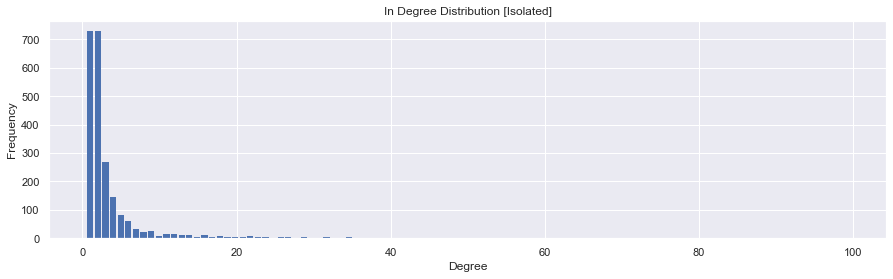

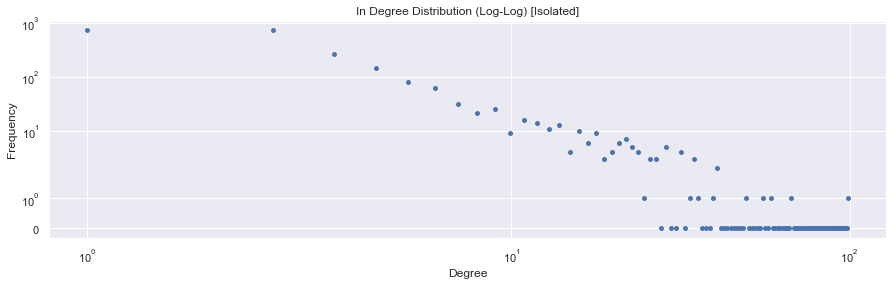

In [642]:
figsizew = 15
figsizeh = 4

# IN DEGREE DISTRIBUTION
artists_in_degrees = [d for d in np.array(list(in_degrees.values())) if d > 0]
artists_in_H, artists_in_bins = np.histogram(artists_in_degrees,max(artists_in_degrees))

# Normal degree distribution
plt.figure(figsize = (figsizew,figsizeh))
plt.bar(artists_in_bins, np.insert(artists_in_H, 0, artists_in_H[0]), edgecolor='none')
plt.ylabel('Frequency')
plt.xlabel('Degree')
plt.title('In Degree Distribution [Isolated]')
plt.show()

# Log-Log degree distribution
plt.figure(figsize = (figsizew,figsizeh))
plt.scatter(artists_in_bins, np.insert(artists_in_H, 0, artists_in_H[0]), s=15)
plt.xscale("symlog")
plt.yscale('symlog')
plt.ylabel('Frequency')
plt.title('In Degree Distribution (Log-Log) [Isolated]')
plt.xlabel('Degree')
plt.show()

It can be seen from the normal degree distribution above, that most nodes only have a few amount of in-going links (number of other artists featuring on one's own track). The **Degree**-axis correctly spreads to an amount around 100 (The top feautring in-going artist list at 99, see ***"Most featuring artists"***). High degree numbers are hard to see though, as the **Frequency**-axis line on zero is wider than the height of the bars produced for nodes with degrees over 30. These nodes will appear if the plot is changed to a scatter plot, as points are then drawn on top of axis lines - like with the Log-Log plot above and the total degree plot further below.

The vast majority only have 1 or 2 links, but values up to around 30 is noticable on the plot for, meaning at least a few artists in total have this amount - making it not totally uncommon.

The log-log plot indicates that the network follows a power-law distribution (exponentional growth similar to a scale free network). 

#### Out degree distribution

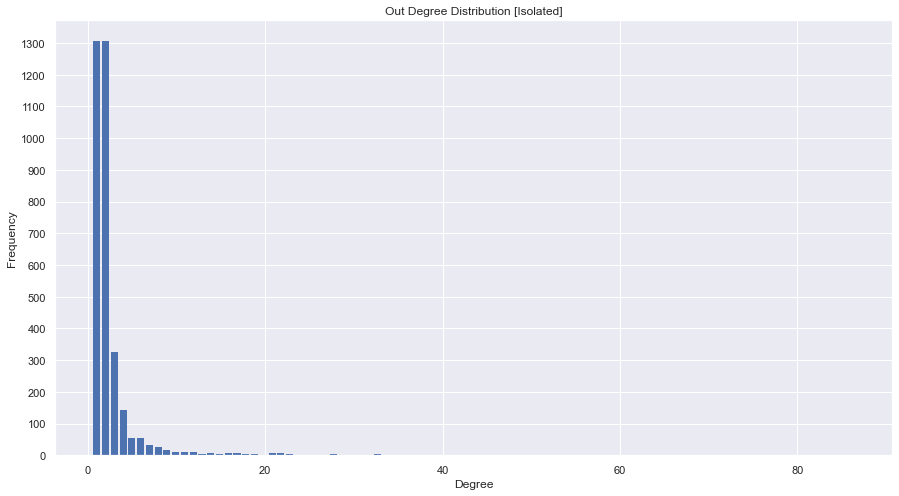

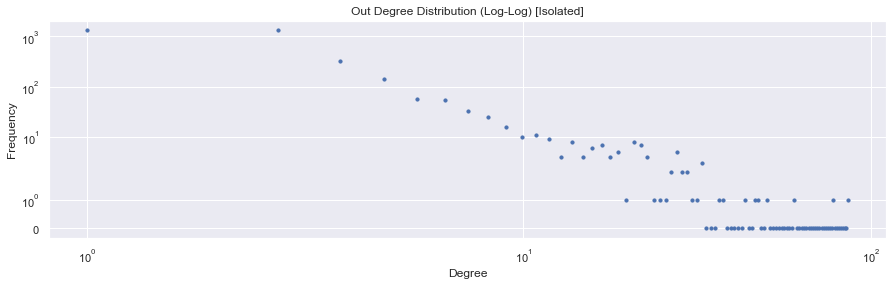

In [645]:
# OUT DEGREE DISTRIBUTION
artists_out_degrees = [d for d in np.array(list(out_degrees.values())) if d > 0]
artists_out_H, artists_out_bins = np.histogram(artists_out_degrees,max(artists_out_degrees))

# Normal degree distribution
plt.figure(figsize = (figsizew,figsizeh*2))
plt.bar(artists_out_bins, np.insert(artists_out_H, 0, artists_out_H[0]), edgecolor='none')
plt.ylabel('Frequency')
plt.xlabel('Degree')
plt.yticks(np.arange(0, 1400, step=100))
plt.title('Out Degree Distribution [Isolated]')
plt.show()

# Log-Log degree distribution
plt.figure(figsize = (figsizew,figsizeh))
plt.scatter(artists_out_bins, np.insert(artists_out_H, 0, artists_out_H[0]), s=10)
plt.xscale("symlog")
plt.yscale('symlog')
plt.ylabel('Frequency')
plt.title('Out Degree Distribution (Log-Log) [Isolated]')
plt.xlabel('Degree')
plt.show()

Both the normal and log-log degree distribution of out-going links (number of times an artist features on other's tracks) are very similar to the distribution of in-going links adressed before.

The vast majority still only have a degree of 1 or 2, but the **Frequency**-count rises to almost double the amount (just above 1300 compared to above 700). To show then as precicely as possible in relation to each other, the plot for outgoing degrees has been printet with twize the height and double the amount of ticks on the y-axis. By doing this, it becomes very clear that they follow a similar evolvement in regar to link count for values higher than 2.

The maxmimum amount is slighty lower (maxing out just above 80), but higher degree counts are generally speaking more likely for in-going than out-going, as the outgoing distribution is less widespread with almost double the amount of nodes with only 1 or 2 links. This is believed to be due to smaller artists, who only make the cut on the Billboard chart by featuring on other and bigger artist's songs.

Thus, it must be consirered more likely for polular artists to have more artist feature on their own songs, than the other way around. This makes good sense, as singles more often than not sell in relation to the artist's popularity. In other words, a collab will probably sell better, if the bigger name is listed first.

The log-log plot also indicates a power-law for this distribution as well.

#### Total degree distribution

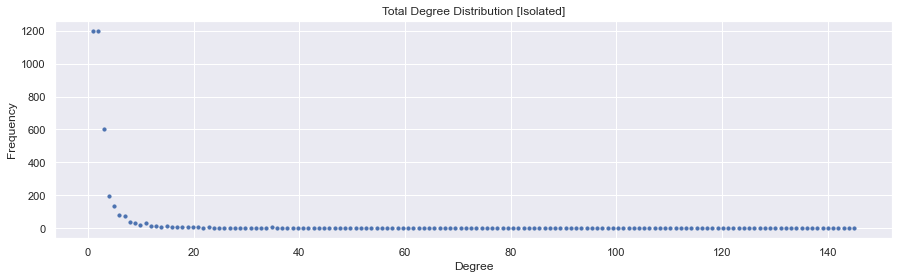

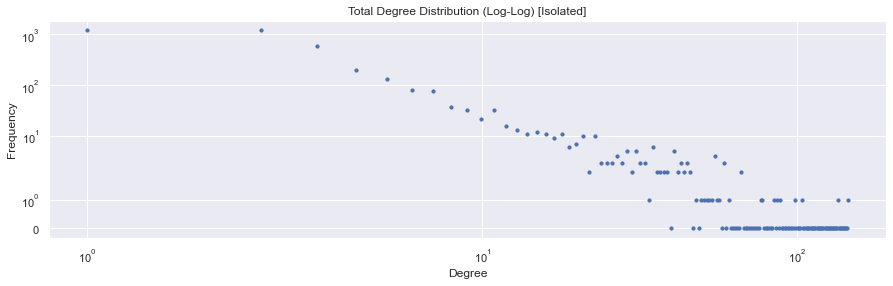

In [638]:
# OUT DEGREE DISTRIBUTION
artists_total_degrees = [d for d in np.array(list(total_degrees.values())) if d > 0]
artists_total_H, artists_total_bins = np.histogram(artists_total_degrees,max(artists_total_degrees))

# Normal degree distribution as scatter plot to be more visible
plt.figure(figsize = (figsizew,figsizeh))
plt.scatter(artists_total_bins, np.insert(artists_total_H, 0, artists_total_H[0]), s=10)
plt.ylabel('Frequency')
plt.xlabel('Degree')
plt.title('Total Degree Distribution [Isolated]')
plt.show()

# Log-Log degree distribution
plt.figure(figsize = (figsizew,figsizeh))
plt.scatter(artists_total_bins, np.insert(artists_total_H, 0, artists_total_H[0]), s=10)
plt.xscale("symlog")
plt.yscale('symlog')
plt.ylabel('Frequency')
plt.title('Total Degree Distribution (Log-Log) [Isolated]')
plt.xlabel('Degree')
plt.show()

For the total (undirectional) distribution, the **Degree**-axis counts naturally extends to almost a 150, as both in- and outgoing edges are accounted for. This time around the normal distribution is shown as a scatter plot, as it is otherwise very hard to see the distribution.

The log-log distributions follows a slightly more clear looking power-law than the in- and out degree distributions on their own.

Both the normal and log-log distribution plot looks undeniable very similar to the distribution of a scale free network this time around at least.

#### Comparison to a scale free network

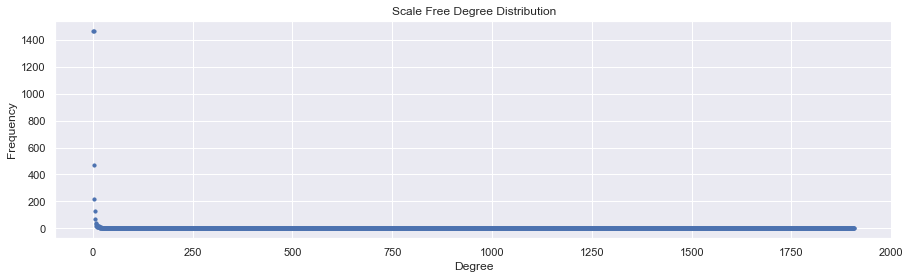

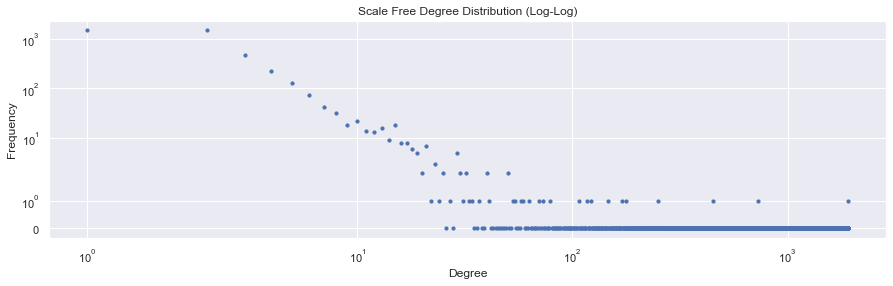

In [115]:
# GENERATING SCALE FREE NETWORK WITH SAME MUMBER OF NODES
scale_free_graph = nx.scale_free_graph(len(G_no_isolated))
scale_free_degrees = [d for d in np.array(list(dict(scale_free_graph.degree()).values())) if d > 0]
scale_free_graph_H, scale_free_graph_bins = np.histogram(scale_free_degrees,max(scale_free_degrees))

# Plotting normal degree distribution of a scale free network
plt.figure(figsize = (figsizew,figsizeh))
plt.scatter(scale_free_graph_bins, np.insert(scale_free_graph_H, 0, scale_free_graph_H[0]), s=10)
plt.ylabel('Frequency')
plt.xlabel('Degree')
plt.title('Scale Free Degree Distribution')
plt.show()

# Plotting Log-Log degree distribution of a scale free network
plt.figure(figsize = (figsizew,figsizeh))
plt.scatter(scale_free_graph_bins, np.insert(scale_free_graph_H, 0, scale_free_graph_H[0]), s=10)
plt.xscale("symlog")
plt.yscale('symlog')
plt.ylabel('Frequency')
plt.title('Scale Free Degree Distribution (Log-Log)')
plt.xlabel('Degree')
plt.show()

For a scale free network with the same amount of nodes as illustrated above, the distribution does indeed looks very similar to the Top Billboard Network.

The **Frequency** count for the vast majority is quite similar, but the **Degreecount** goes way higher and is much more widespread, with degreecounts going all the way up around 1900.

Some general statistics can easily be computed regarding the two networks:

In [127]:
def network_properties(g):
    N = len(g.nodes())
    e = len(g.edges())
    avg_d = 2 * e / N
    p = avg_d / (N-1)
    print(" - Average degree: {}".format(avg_d))
    print(" - Probability of connection: {}".format(p))
    print(" - Number of nodes: {}".format(N))
    print(" - Number of links: {}\n".format(e))

print("Billboard Top Artists Network:")
network_properties(G_no_isolated)

print("Scale Free Network:")
network_properties(scale_free_graph)

Billboard Top Artists Network:
 - Average degree: 3.5785060975609757
 - Probability of connection: 0.0013642798694475699
 - Number of nodes: 2624
 - Number of links: 4695

Scale Free Network:
 - Average degree: 4.456554878048781
 - Probability of connection: 0.0016990296904494018
 - Number of nodes: 2624
 - Number of links: 5847



These are also fairly similar. However, besides the fixed number of nodes, all attributes are a bit higher for the generated Scale Free Network.

It is completely natural that with a higher average degree and probability of connection, alsongside more edges in total (due to the higher probabality of connection), that the normal distribution will be more spread as shown on the normal distribution.

These small attribute differences also causes the log-log distribution to follow a powerlaw more clearly - which was also expected.

# 3. Tools, theory and analysis

## Visualization of Network

Before harder computational analysis of the created network and its attributes shall begin, it is a good idea to get a proper understanding of what the network actually looks like and how the nodes (artists) connects to each other.

For this, the network will first be visualized by drawing all nodes and edges - including directions. 

Secondly, the largest connected component will be drawn to get a better look at the more important/well-integrated part of the network.

To visualize both drawings the library **ForceAtlas2** has been used to map node locations in relation to each other, to achieve the best and most clear looking graph representations. Node sizes are determined by degree. Genres could have been a good attribute to color nodes by, but as most artists don't belong to one single genre, and since Genius' api doesn't support this feature either, the network doesn't support this feature. Therefore, all nodes and links are represented in blue and light grey respectively.

NetworkX's **draw_networkx_nodes** and **draw_networkx_edges** are used to actually draw the graphs, as the network already relies on this library. It is also a good and robust tool in general.

### Whole Network (directed)

In [24]:
# Degrees to determine node size whole network
node_size_all = list(dict(G.degree()).values())
node_size_all_adjusted = [d*2+1 for d in node_size_all]

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [11:44<00:00,  2.84it/s]


BarnesHut Approximation  took  56.99  seconds
Repulsion forces  took  637.30  seconds
Gravitational forces  took  0.09  seconds
Attraction forces  took  0.25  seconds
AdjustSpeedAndApplyForces step  took  3.44  seconds


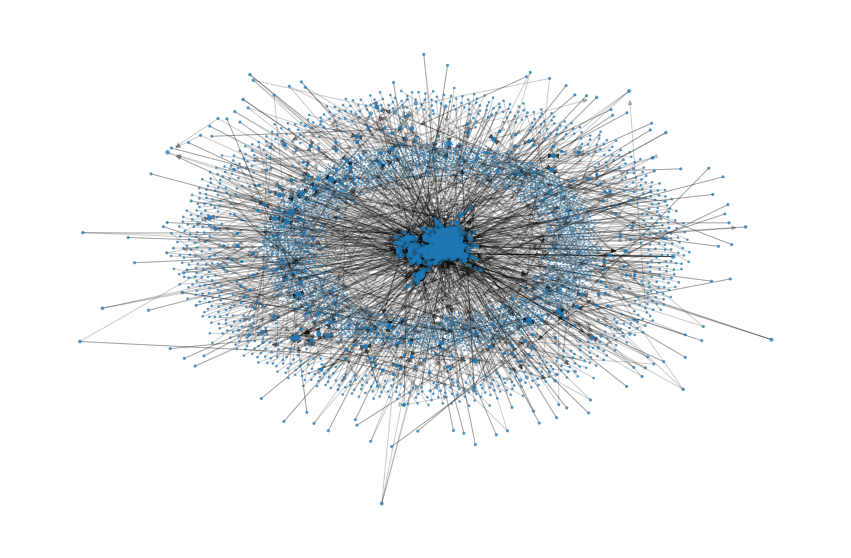

In [14]:
# Whole Network with isolated 2000 iterations
plt.figure(figsize = (15,10))
forceatlas2 = ForceAtlas2(
                      # Behavior alternatives
                      outboundAttractionDistribution=False,  # Dissuade hubs
                      edgeWeightInfluence=0.5,
                      # Performance
                      jitterTolerance=0.2, # Tolerance
                      barnesHutOptimize=True,
                      barnesHutTheta=0.6,
                      # Tuning
                      scalingRatio=5.0,
                      strongGravityMode=True,
                      gravity=1,
                      # Log
                      verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)
nx.draw_networkx_nodes(G, positions, node_size=node_size_all_adjusted, with_labels=False, alpha=0.6)
nx.draw_networkx_edges(G, positions,alpha=0.2)
plt.axis('off')
plt.show()

It can be seen that popular nodes (with high featuring/degree count) cluster together near the center. Then another cluster of nodes creates a circle around the center, linking to both very popolar nodes, but also less frequently connected nodes. These less frequently connected nodes form another circle themselves outside yet again.

All in all, nodes are grouped into three main layers/ranks of popularity.

### Largest connected component (undirected)

In [332]:
# Transform to undirected:
lcc_un = lcc.to_undirected()

# Degrees to determine node size lcc undirected
size_list = list(dict(lcc_un.degree()).values())

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:08<00:00, 10.62it/s]


BarnesHut Approximation  took  16.99  seconds
Repulsion forces  took  167.59  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.35  seconds
AdjustSpeedAndApplyForces step  took  1.14  seconds


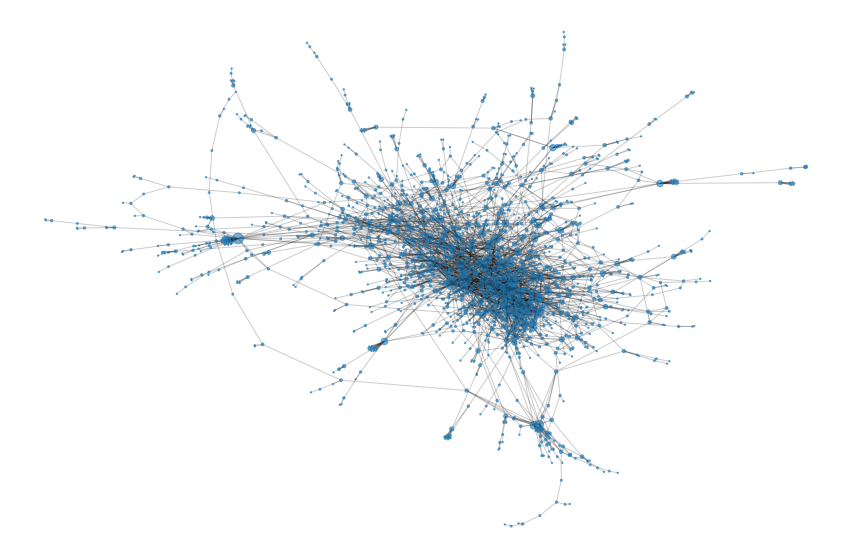

In [13]:
# Largest connected component 2000 iterations
plt.figure(figsize = (15,10))
forceatlas2 = ForceAtlas2(
                      # Behavior alternatives
                      outboundAttractionDistribution=False,  # Dissuade hubs
                      edgeWeightInfluence=0.5,
                      # Performance
                      jitterTolerance=0.2, # Tolerance
                      barnesHutOptimize=True,
                      barnesHutTheta=0.6,
                      # Tuning
                      scalingRatio=5.0,
                      strongGravityMode=True,
                      gravity=1,
                      # Log
                      verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(lcc_un, pos=None, iterations=2000)
nx.draw_networkx_nodes(lcc_un, positions, node_size=[d*2 for d in size_list], with_labels=False, alpha=0.6)
nx.draw_networkx_edges(lcc_un, positions,alpha=0.2)
plt.axis('off')
plt.show()

When looking at the largest connected component above as an undirected graph (which removes some distortion from the eyes and focuses more on generalised relationships), all nodes naturally cluster well together. However, some outerly subclusters still do exist between artists.

This will be interesting to look into when the grah is sepreated into communites later.

## Collaborations

### Most featuring artists

Popularity can be both easy and hard to measure - it all depends on what type of popularity you're measuring. The following section investigates popularity by connectedness, which means which nodes links to most others. As the network is directional, this can be divided into both in-, out and total degree count. Top 10 most connected artist, which means the most commonly featured ones, are found by sorting through all nodes of the network.

By looking at which artists appear most often the Billboard chart in relation to others, you also get a clear indication of who music listeners enjoys to see the most in collaborations, and if there exist a pattern in this behavior.

The section could have been placed in **Basic Stats** as well, but due to the accompaning analytical work, it was decided to be a better fit in this section.

In [624]:
# Sort degreecounts
in_degrees_sorted_max = {k: v for k, v in sorted(in_degrees.items(), key=lambda item: item[1], reverse=True)}
out_degrees_sorted_max = {k: v for k, v in sorted(out_degrees.items(), key=lambda item: item[1], reverse=True)}
total_degrees_sorted_max = {k: v for k, v in sorted(total_degrees.items(), key=lambda item: item[1], reverse=True)}

print("Top 10 artists with highest ingoing degree")
i = 0
for k, v in in_degrees_sorted_max.items():
    if(i == 10):
        break
    print("%i: %s (%i)" %(i+1, k, v))
    i += 1

print("\nTop 10 artists with highest outgoing degree")
i = 0
for k, v in out_degrees_sorted_max.items():
    if(i == 10):
        break
    print("%i: %s (%i)" %(i+1, k, v))
    i += 1

print("\nTop 10 artists with highest total degree")
i = 0
for k, v in total_degrees_sorted_max.items():
    if(i == 10):
        break
    print("%i: %s (%i)" %(i+1, k, v))
    i += 1

Top 10 artists with highest ingoing degree
1: DJ Khaled (99)
2: Drake (67)
3: Artists United Against Apartheid (58)
4: Kanye West (55)
5: Lil Wayne (49)
6: JAY-Z (40)
7: Metro Boomin (40)
8: Travis Scott (39)
9: Meek Mill (35)
10: Earth, Wind (34)

Top 10 artists with highest outgoing degree
1: Lil Wayne (86)
2: Drake (78)
3: Nicki Minaj (60)
4: Future (50)
5: Travis Scott (47)
6: Chris Brown (46)
7: Kanye West (43)
8: Young Thug (37)
9: JAY-Z (36)
10: Earth, Wind (32)

Top 10 artists with highest total degree
1: Drake (145)
2: Lil Wayne (135)
3: DJ Khaled (103)
4: Kanye West (98)
5: Nicki Minaj (88)
6: Travis Scott (86)
7: Future (84)
8: Chris Brown (77)
9: JAY-Z (76)
10: Earth, Wind (66)


By analyzing the most featuring artists, for both in-, out- and total degree count found by our algorithm with the help of Genius' api, it is clear that most artists belong to the music genre **rap**.

According to Wikipedia, they categorize like so:

**Rappers (Hip Hop)**:
* Drake (3)
* Kanye West (4)
* Lil Wayne (5)
* Travis Scott (6)
* JAY-Z (10)
* Nicki Minaj (11)
* Future (12)
* Young Thug (13)
* Meek Mill (14)

**DJ's (Hip Hop + songwriters)**:
* DJ Khaled (2)
* Metro Booming (7)

**Regular singers (R&B + Pop + hiphop)**:
* Chris Brown (8)
* Earth, Wind & Fire (9)

**Artists gatherings**:
* Artists United Against Apartheid (1)

It is important to note that multiple rappers, like "**Nicki Minaj**" for instance, also reckognises as singers. However, as rap being their primary performing form, they have been grouped like so.

The artist gathering "**Artists United Against Apartheid**" is a collection of artist who gathered together as one group to produce a single song called "Sun City". As 58 artists featured on this track, this one-time artist group is due to the implemented algorithm ranked as one of the highest valued in-going degree nodes.

**NB**: It is important to notice that "**Earth, Wind**" refers to "**Earth, Wind & Fire**". The band name has been split up into two artists by the algorithm explained in the **Network Creation"** section (as & usually refers to different primary artists on Genius). The band therefore rank as number 10 and 11 respectively with the exact same number of ingoing artists (as both "artists" have ingoing edges from all featuring artitst, look **below** for a list including number 11). This is one example of where the algorithm isn't optimal, but it is extremely hard to prepare for every possible real world scenario, and as "&" almost always means seperation of main artists on Genius' api, it was decided not to change the chosen approach.

(1) https://en.wikipedia.org/wiki/Artists_United_Against_Apartheid

(2) https://en.wikipedia.org/wiki/DJ_Khaled

(3) https://en.wikipedia.org/wiki/Drake_(musician)

(4) https://en.wikipedia.org/wiki/Kanye_West

(5) https://en.wikipedia.org/wiki/Lil_Wayne

(6) https://en.wikipedia.org/wiki/Travis_Scott

(7) https://en.wikipedia.org/wiki/Metro_Boomin

(8) https://en.wikipedia.org/wiki/Chris_Brown

(9) https://en.wikipedia.org/wiki/Earth,_Wind_%26_Fire

(10) https://en.wikipedia.org/wiki/Jay-Z

(11) https://en.wikipedia.org/wiki/Nicki_Minaj

(12) https://en.wikipedia.org/wiki/Future_(rapper)

(13) https://en.wikipedia.org/wiki/Young_Thug

(14) https://en.wikipedia.org/wiki/Meek_Mill

Top 11 artists with highest ingoing degree, to include both parts of the band "**Earth, Wind & Fire**":

In [646]:
print("Top 11 artists with highest ingoing degree")
i = 0
for k, v in in_degrees_sorted_max.items():
    if(i == 11):
        break
    print("%i: %s (%i)" %(i+1, k, v))
    i += 1

Top 11 artists with highest ingoing degree
1: DJ Khaled (99)
2: Drake (67)
3: Artists United Against Apartheid (58)
4: Kanye West (55)
5: Lil Wayne (49)
6: JAY-Z (40)
7: Metro Boomin (40)
8: Travis Scott (39)
9: Meek Mill (35)
10: Earth, Wind (34)
11: Fire (34)


### Connectedness

We wanted to see the trend in collaborations over the years. To do this, we looked at all edges in the dataset. We wanted the data to be normalized, so we also had to count the amount of songs for each year. The year of a song is determined by the first time it appears on the Billboard list.  
We only wanted to count each song once, and for this we had to go by song title. This is not ideal, as two different songs with the same name would not be counted correctly. For the edges, we set up a method which took every edge (which contains the name of the song in question), followed the edge to the node, found the song by title and returned the release year.  
This created two sets of data. A dataset containing the total amount of songs for each year and a dataset containing the amount of collaborations each year. With this we created a visualization of collaborations per song for each year, visualized as a bar graph.

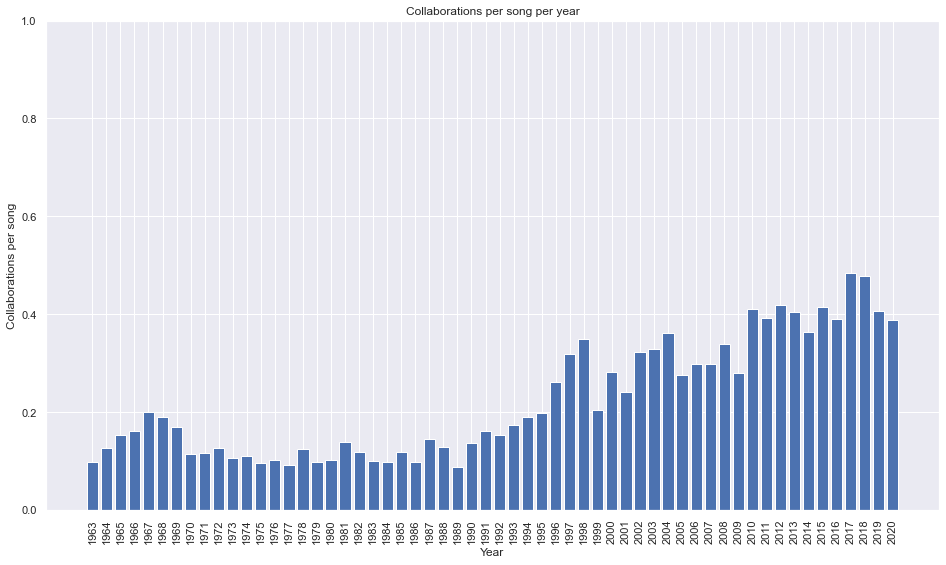

In [84]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

figsizew = 16
figsizeh = 9

totSongsDict = {k:0 for k in range(1963,2021)}
edgesDict = {k:0 for k in range(1963,2021)}
exhaustedHits = []
network = nx.read_gpickle("./fullNetworkSentiment.gpickle")
edges = network.edges(data=True)
nodes = network.nodes(data=True)

# Construct a dictionary of years: numSongs
# Excludes duplicates via exhaustedHits
for node in list(nodes):
    if('songs' not in node[1]):
        continue
    songs = node[1]['songs']
    for title, v in songs.items():
        if(title in exhaustedHits):
            continue
        exhaustedHits.append(title)
        year = v['placements'][0]['year']
        totSongsDict[int(year)] = totSongsDict[int(year)] + 1
        
# exhaustedHits is reset
exhaustedHits = []
     
# Construct a dictionary of years: collaborations
# Excludes duplicates via exhaustedHits
for edge in edges:
    node = network.nodes(data=True)[edge[1]]
    song = node['songs'][edge[2]['label']]
    if(song in exhaustedHits):
        continue
    exhaustedHits.append(song)
    year = int(song['placements'][0]['year'])
    edgesDict[year] = edgesDict[year] + 1
        
plt.figure(figsize = (figsizew,figsizeh))
data = [(k,v) for k,v in edgesDict.items()]
data = [(a,b/totSongsDict[a]) for (a,b) in data]
plt.bar([e[0] for e in data], [e[1] for e in data])
plt.xlabel('Year')
plt.xticks(range(1963,2021,1), rotation=90)
plt.ylabel('Collaborations per song')
plt.ylim(0,1)
plt.title('Collaborations per song per year')
plt.show()

The graph shows the relation between total songs and the amount of songs which have been collaboratory work, where 
0 is if no songs are collaborative works, and a value of 1 is if every song is a collaboration.  
The results show a considerable trend towards more collaboration. It is also interesting to see how some 
of the earlier years appear to have more collaboration between artists than the years 1970-1989. 

## Most Popular


There are a lot of different ways to measure the success of a song or an artist, for this section success is measured by the number of weeks a song or an artist have been on billboards hot 100. We simply just go though the entire network and count the number of placements a song and use that to find the most popular songs though history.

In [89]:
topSongs = {}

def highestPosition(placements):
    higestPosition = 100
    #Look through placements get highest
    for placement in placements:
        if higestPosition > int(placement['rank']):
            higestPosition = int(placement['rank'])
        
    return [len(placements), higestPosition]

for node in network.nodes(data=True):
    if 'songs' in node[1]:
        for k, v in node[1]['songs'].items():
            key = k + " By " + node[0]
            topSongs[key] = highestPosition(v['placements'])

In [91]:
sortedTopSongs = {k: v for k, v in sorted(topSongs.items(), key=lambda item: item[1], reverse=True)}

print("Top 10 songs with highest number of weeks on billboard hot 100")
i = 0
for k, v in sortedTopSongs.items():
    if(i == 10):
        break
    print("%i: %s (%i)" %(i+1, k, v[0]))
    i += 1

Top 10 songs with highest number of weeks on billboard hot 100
1: Radioactive By Imagine Dragons (87)
2: Sail By AWOLNATION (79)
3: I'm Yours By Jason Mraz (76)
4: How Do I Live By LeAnn Rimes (69)
5: Counting Stars By OneRepublic (68)
6: Party Rock Anthem By LMFAO (68)
7: Rolling In The Deep By Adele (65)
8: Before He Cheats By Carrie Underwood (64)
9: You And Me By Lifehouse (62)
10: Ho Hey By The Lumineers (62)


What is surprising for this list is that a lot of these song hasn’t necessarily reached the top position on the chart but has still managed to stay on the hot 100. 


In [94]:
sortedTopSongs = {k: v for k, v in sorted(topSongs.items(), key=lambda item: item[1], reverse=True)}

print("Top 10 songs with peak positions on billboard hot 100")
i = 0
for k, v in sortedTopSongs.items():
    if(i == 10):
        break
    print("%i: %s (%i)" %(i+1, k, v[1]))
    i += 1

Top 10 songs with peak positions on billboard hot 100
1: Radioactive By Imagine Dragons (3)
2: Sail By AWOLNATION (17)
3: I'm Yours By Jason Mraz (6)
4: How Do I Live By LeAnn Rimes (2)
5: Counting Stars By OneRepublic (2)
6: Party Rock Anthem By LMFAO (1)
7: Rolling In The Deep By Adele (1)
8: Before He Cheats By Carrie Underwood (8)
9: You And Me By Lifehouse (5)
10: Ho Hey By The Lumineers (3)


To calculate the most popular artist the count of weeks a song has been on the hot 100 chart is assigned to the artist or artists that have made the song. 

In [64]:
topArtists = {}

for node in network.nodes(data=True):
    if 'songs' in node[1]:
        for k, v in node[1]['songs'].items():
            if node[0] in topArtists.keys():
                topArtists[node[0]] += len(v['placements'])
            else:
                topArtists[node[0]] = len(v['placements'])

In [65]:
sortedTopArtists = {k: v for k, v in sorted(topArtists.items(), key=lambda item: item[1], reverse=True)}

print("Top 10 artists with highest number of weeks on billboard hot 100")
i = 0
for k, v in sortedTopArtists.items():
    if(i == 10):
        break
    print("%i: %s (%i)" %(i+1, k, v))
    i += 1

Top 10 artists with highest number of weeks on billboard hot 100
1: Drake (1316)
2: Taylor Swift (1021)
3: Madonna (867)
4: Rihanna (853)
5: Kenny Chesney (827)
6: Elton John (820)
7: Chris Brown (806)
8: Usher (759)
9: Tim McGraw (751)
10: Maroon 5 (719)


### Christmas Edition

As a supplement to the sentiment analysis performed in section **Sentimental Analysis**, we would like to take a closer look on the most popular Christmas songs in our network. Our assumption is that Christmas songs generally have a high sentimental value, since *it's the most wonderful time of year*.

The way we identify and separate Christmas songs amongst the rest, is by going through the network discarding all the songs that have been on the hot 100 chart in the weeks from 5 to 44, which correlates to all months with November, December and January excluded. We assume that Christmas songs becomes popular on a yearly basis, therefore we make sure that it can only be a Christmas song if it appears on the chart multiple years.


In [95]:
christmasSongs = {}

for node in network.nodes(data=True):
    if 'songs' in node[1]:
        #Go through all the songs in the network
        for k, v in node[1]['songs'].items():
            countYears = []
            isChristmasSong = True
            #Go through all the times the song has been on hot 100
            for placement in v['placements']:
                #Check if the song has been popular outside the Christmas months 
                if 4 < int(placement['week']) and int(placement['week']) < 45:
                    isChristmasSong = False
                #Add the year if placement is in November or December and not in countYears
                elif isChristmasSong and 44 < int(placement['week']) and placement['year'] not in countYears:
                    countYears.append(placement['year'])
            #Check if songs has been popular for more then one year
            if not v['lyrics'] == "404 Error" and len(countYears) > 1:
                key = k + " By " + node[0]
                #Add entry
                christmasSongs[key] = [countYears, v['sVal']]

In [96]:
sortedChristmasSongs = {k: v for k, v in sorted(christmasSongs.items(), key=lambda item: item[1], reverse=True)}

print("Top 10 Christmas songs with with there sentimental values")
i = 0
for k, v in sortedChristmasSongs.items():
    if(i == 10):
        break
    print("%i: %s (%f)" %(i+1, k, v[1]))
    i += 1

Top 10 Christmas songs with with there sentimental values
1: Golden By Harry Styles (5.943699)
2: Feliz Navidad By José Feliciano (6.318779)
3: Sleigh Ride By The Ronettes (6.167895)
4: Rudolph The Red-Nosed Reindeer By Gene Autry (5.926263)
5: Let It Snow, Let It Snow, Let It Snow By Dean Martin (5.430101)
6: It's The Most Wonderful Time Of The Year By Andy Williams (5.835600)
7: Last Christmas By Wham! (5.707113)
8: Jingle Bell Rock By Bobby Helms (5.870252)
9: Rockin' Around The Christmas Tree By Brenda Lee (6.225000)
10: The Feeling By Justin Bieber (5.944372)


By looking at the top 10 found Christmas songs, we see a correlation between a high sentimental value and the found song being a Christmas song, but to get an overall picture of the situation, we calculate the average sentimental value for all found Christmas songs.

In [56]:
average = 0
count = 0
for k, v in sortedChristmasSongs.items():
    if v[1] > 0:
        average += v[1]
        count += 1

average = average/count
print("Average sentimental value of Christmas songs: " + str(average))
max(sortedChristmasSongs)

Average sentimental value of Christmas songs: 5.7099050166671095


Just to compare, the average sentimental score for songs outside the Christmas genre is around 5.55 to 5.6, compared to these number it becomes clear that Christmas songs are generally more positive. 

But if we inspect the top 10 Christmas songs list a bit closer, we notice that not all of the entries are actually Christmas songs (entries 3, 7, 9 and 10). A way to further filter our Christmas songs list is by analyzing if a song actually mentions anything about Christmas. The way we do this creating a Christmas word list with the help of *teachstarter’s* Christmas Vocabulary which can be found on [this link]( https://www.teachstarter.com/au/teaching-resource/christmas-word-wall-vocabulary/). 

In [29]:
christmasWords = []

def downloadProfanityList():
    
    # Construct query with leter
    query = "https://www.teachstarter.com/au/teaching-resource/christmas-word-wall-vocabulary/"
    print(query)
    # Retrieve data
    request = session.get(query)
        
    # Extract html
    html = request.text
    # Parse as beautiful soup
    soup = BeautifulSoup(html, 'html.parser')
    # Get Christmas table
    table = soup.find_all('table', class_='table table-bordered table-responsive')
    words_raw = table[0].find_all('td')
    
    #Format Christmas list
    for word_raw in words_raw:
        wordlist = word_raw.text.split()
        if len(wordlist) > 1:
            word = [' '.join(wordlist)]
        else:
            word = wordlist
        christmasWords.append(word[0])
        
downloadProfanityList()
print(christmasWords)

https://www.teachstarter.com/au/teaching-resource/christmas-word-wall-vocabulary/
['Christmas', 'merry', 'Santa Claus', 'Saint Nicholas', 'Kris Kringle', 'elves', 'jolly', 'reindeer', 'carols', 'caroling', 'carolers', 'mistletoe', 'frankincense', 'myrrh', 'nativity', 'Xmas', 'yuletide', 'tinsel', 'stocking', 'fruitcake', 'chimney', 'Jesus', 'pinecone', 'tidings', 'Rudolph', 'sleigh', 'holiday', 'holly', 'ornaments', 'Scrooge', 'sled', 'snowball', 'St. Nicks', 'snowman', 'rejoice', 'Father Christmas', 'Christmas Eve', 'Christmas tree', 'Jack Frost', "Santa's helpers", "Santa's workshop", 'Christmas carol', 'Christmas card', 'Frosty the Snowman', 'December 25', 'sleigh bells', 'gingerbread house', 'North Pole', 'plum pudding', "season's greetings"]


By going through the network once more, but this time also checking if a song has any Christmas words, we get the following top 10 Christmas song. 

In [97]:
christmasSongsFiltered = {}

for node in network.nodes(data=True):
    if 'songs' in node[1]:
        #Go through all songs in the network
        for k, v in node[1]['songs'].items():
            countYears = []
            isChristmasSong = True
            inChristmasWords = False
            #Make sure the song has lyrics
            if not v['lyrics'] == "404 Error":
                #Go through all the times the song has been on hot 100
                for placement in v['placements']:
                    #Check if the song has been popular outside the Christmas months
                    if 4 < int(placement['week']) and int(placement['week']) < 45:
                        isChristmasSong = False
                    #Add the year if placement is in November or December and not in countYears
                    elif isChristmasSong and 44 < int(placement['week']) and placement['year'] not in countYears:
                        countYears.append(placement['year'])
                #Go though tokens of lyrics
                for token in tokenize(v['lyrics']):
                    #Check if the token is a Christmas word
                    if token in christmasWords:
                        inChristmasWords = True
                        break

                #Check if songs has been popular for more then one year
                if isChristmasSong and inChristmasWords and len(countYears) > 1:
                    key = k + " By " + node[0]
                    #Add entry
                    christmasSongsFiltered[key] = [countYears, v['sVal']]

In [98]:
christmasSongsFiltered = {k: v for k, v in sorted(christmasSongsFiltered.items(), key=lambda item: item[1], reverse=True)}

print("Top 10 sorted Christmas songs with with there sentimental values")
i = 0
for k, v in christmasSongsFiltered.items():
    if(i == 10):
        break
    print("%i: %s (%f)" %(i+1, k, v[1]))
    i += 1

Top 10 sorted Christmas songs with with there sentimental values
1: Feliz Navidad By José Feliciano (6.318779)
2: Sleigh Ride By The Ronettes (6.167895)
3: Rudolph The Red-Nosed Reindeer By Gene Autry (5.926263)
4: It's The Most Wonderful Time Of The Year By Andy Williams (5.835600)
5: Last Christmas By Wham! (5.707113)
6: Jingle Bell Rock By Bobby Helms (5.870252)
7: Rockin' Around The Christmas Tree By Brenda Lee (6.225000)
8: All I Want For Christmas Is You By Mariah Carey (5.966992)
9: Little Darlin' By J. B. Priestley (5.549218)
10: Holly Holy By Junior Walker (5.892471)


With the average sentimental value being around 5.9.

In [55]:
average = 0
count = 0
for k, v in christmasSongsFiltered.items():
    if v[1] > 0:
        average += v[1]
        count += 1

average = average/count
print("Average sentimental value of Christmas songs: " + str(average))

Average sentimental value of Christmas songs: 5.941095662414256


### Most popular terms in hit songs

Some terms are naturally a lot more common in songs than others. As the billboard chart only contains the most popular songs, it is assumed that the most common terms relates to the most basic subject of all: romance. If this is true, and/or if other subjects top the list, will be investigated in the following section.

This is done by aggregating lyrics from every song defined in the network, by iterating all artists.

In [608]:
def getLyricsAggregated(artist):
    lyrics = ''
    # Check if artist contains any songs.
    if bool(G.nodes[artist]):
        for title in G.nodes[artist]['songs'].keys():
            if G.nodes[artist]['songs'][title]['lyrics'] != '404 Error':
                lyric = G.nodes[artist]['songs'][title]['lyrics']
                lyrics += lyric
    return lyrics

all_lyrics = []

# Iterates all artists and concatenates all lyrics associated with them
for artists in G.nodes():
    lyrics_raw = getLyricsAggregated(artists)
    tokens = word_tokenize(lyrics_raw)
    words = [w.lower() for w in tokens if w.isalnum()]
    all_lyrics += words

When all lyrics are concatenated, the total of words equal:

In [617]:
print("Number of words in total: {}" .format(len(all_lyrics)))

Number of words in total: 7749441


To remove commonly used undescriptive words like "and", "or", "that" etc., the library ***nltk*** has been used to filter through these so called **stopwords**. Same library has afterwards been used to create a frequency distribution of all words in the list of aggregated lyric words.

In [610]:
stop_words = stopwords.words('english')
all_tf = list(nltk.FreqDist([w for w in all_lyrics if w not in stop_words]).most_common(len(all_lyrics)))

This gives the following top terms:

In [614]:
print(all_tf[:10])

[('love', 52398), ('like', 47193), ('yeah', 44709), ('got', 44643), ('know', 43965), ('oh', 37951), ('na', 36758), ('baby', 33442), ('get', 33174), ('go', 25799)]


These terms can be shown with the use of a wordcloud also. These wordclouds are created using the library *wordcloud* with parsed frequency lists.

In [583]:
def generate_wordcloud(tftr, name):
    fig_wordcloud = WordCloud(max_font_size=100, max_words=100, 
                                        background_color="white").generate_from_frequencies(dict(tftr))
    plt.figure(figsize=(12,7), frameon=True)
    plt.imshow(fig_wordcloud, interpolation="bilinear")
    plt.title(name, fontsize=30)
    plt.axis('off')
    plt.show()

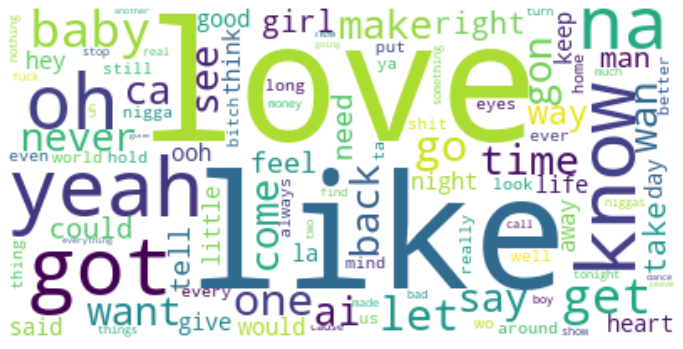

In [612]:
generate_wordcloud(all_tf, "")

Not surprisingly, "love" is the most used term in popular songs. Plenty other romantic words like baby, girl, heart are all common as well. Expression words like "oh", "yeah" and "na" top the list to, as does "know" and "like" itself. Ultimately, the most popular words are, well, very basic.

A few swear words like "nigga" and "bitch" does make the cut. This is assumed to be due to more recent releases, which is investigated further in the Sentament and Swear Word sections.

## Communities of artists

It is expected that artist from different times and genres will navigate in different communities when they collaborate with others. It doesn't seem likely that Heavy Metal bands will collaborate with Jazz musicians very often for instance. The Hot 100 chart mainly covers mainstream popular music, so most songs will naturally belong to more centralized genres - which might make it harder to partioning artists into communties.

The following section will investigate these communities and their unique attributes.

#### Creation of communities

Communities within the network are created by dividing nodes into different groups using the module ***community*** and its built-in function *best_partition*. This function divides nodes into partitions using the Louvain algorithm. This greedy algorithm detects communities by attempting to optimize a partition's modularity. First by locally optimizing for small communities, and secondly by iteratively adding nodes to a community until gobal maximum for an optimization is found.

The method only works with undirected graphs, and to keep it relevant, the largest connected component has been used.

In [445]:
partition_lcc_un = community.best_partition(lcc_un, random_state=13)

Number of communities:

In [446]:
# Number of communities = highest assigned community number in partinioning + 1
num_of_c = max([n for a,n in partition_lcc_un.items()])
print("Number of communities: %i" %(num_of_c+1))

Number of communities: 28


#### Community Distribution

To get a good look of what the communities look like size-wise, they will be plotted below on both normal and logarithmic scale.

To plot these distributions, the assigned community numbers are grouped together and summed up.

In [447]:
# Grouping and sum of all communities
n_c_all = []
for i in range(num_of_c):
    n_c_all.append((i,len([a for a,n in partition_dc.items() if n==i])))

# Sorting the distribution of community sizes
n_c_sorted = sorted(n_c_all, key=lambda t: t[1], reverse=True)

# Remove possible communities with only 1 member
n_c_sorted_multiple = [(c,f) for c,f in n_c_sorted if f > 1]

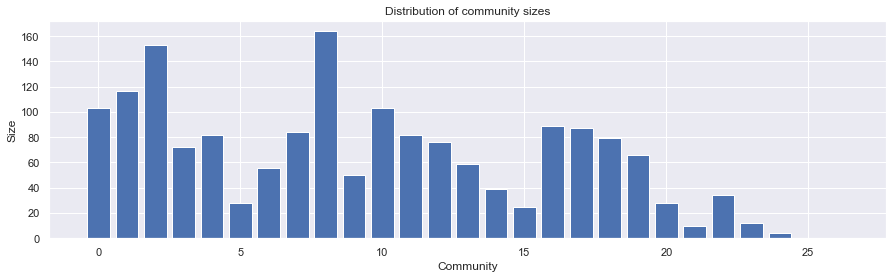

In [652]:
# Normal distribution
plt.figure(figsize = (figsizew,figsizeh))
plt.bar(list(range(0,len(n_c_all))),[f for c,f in n_c_all])
plt.ylabel('Size')
plt.xlabel('Community')
plt.title('Distribution of community sizes')
plt.show()

To see the relation of sizes to each other, the sizes of these grouped communities are shown sorted as well.

The distributions are plotted below on both normal and log-log scale, with **size** reffering to the number of nodes within the community.

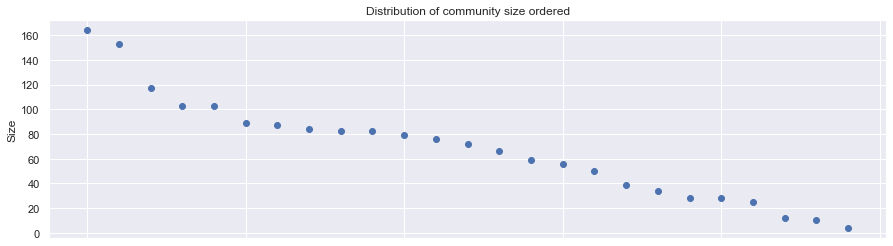

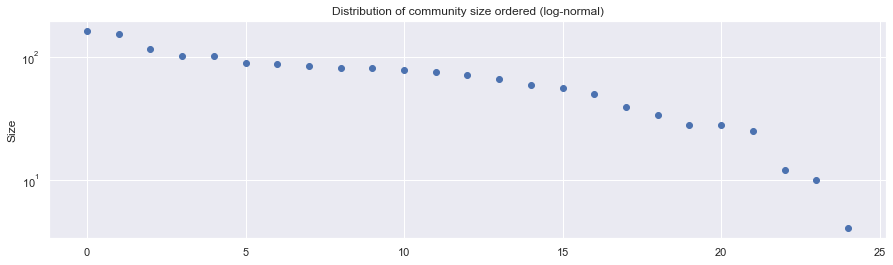

In [654]:
# Normal distribution
plt.figure(figsize = (figsizew,figsizeh))
plt.scatter(list(range(0,len(n_c_sorted_multiple))),[f for c,f in n_c_sorted_multiple])
plt.ylabel('Size')
plt.title('Distribution of community size ordered')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.show()

# Log-Log distribution
plt.figure(figsize = (figsizew,figsizeh))
plt.scatter(list(range(0,len(n_c_sorted_multiple))),[f for c,f in n_c_sorted_multiple])
plt.yscale('symlog')
plt.ylabel('Size')
plt.title('Distribution of community size ordered (log-normal)')
plt.show()

On the normal community distribution plot, it is not completely clear if the community sizes follow a linear or exponentional relationship. 

As the log-normal plot doesn't form a nicely straight line, it is however not expected that the partitioning follows a exponential relationship - at least not a very strong one.

There does seem to be a proportional relation between the sizes of communtites in respect to each other though. This implies that communies generally sort themselves into hierarchies.

### Artists within communities

The 10 biggest communities within the network are examined, to get an idea of what artists prefer to work together. It is expected that artists will tend to collaborate with artist within same or closely related genre and time of popularity, as already explained. However, as popular songs like "Take What You Want" by Post Malone, Ozzy Osbourne and Travis Scott mixes artists from both different times and genres, perhaps the results will surprise [14].

The top artists for each community are sorted by two types of popularity: number of featuring connections and number of songs on the billboard chart in total. This is done sorting dictionaries of artists within each community by different keys. The communited are displayed according to its size, with the biggest one first.

(14) https://www.billboard.com/articles/news/lyrics/8530286/post-malone-take-what-you-want-lyrics-ozzy-osbourne-travis-scott/

In [540]:
# Top N communities
N = 10
n_c = n_c_sorted_multiple[:N]

# Divide artists into their respective communities
commnity_artists = []
for com,count in n_c:
    # Find members of community
    artists = [a for a,n in partition_lcc_un.items() if n==com]
    G_c = G.subgraph(artists)
    commnity_artists.append(G_c)

def sliceDict(d, c):
    list_from_dict = {}
    i = 0
    for k,v in d.items():
        if i >= c:
            break
        list_from_dict[k] = v
        i += 1
    return list_from_dict

def topArtistsByDegree(com, count):
    com_total_degree = dict(com.degree())
    com_t_d_sorted = {k: v for k, v in sorted(com_total_degree.items(), key=lambda item: item[1], reverse=True)}
    return sliceDict(com_t_d_sorted,count)

def topArtistsBySongCount(com, count):
    top_artists_songs = {}
    for artist in com:
        if bool(com.nodes[artist]):
            top_artists_songs[artist] = len(com.nodes[artist]['songs'])
    top_a_s_sorted = {k: v for k, v in sorted(top_artists_songs.items(), key=lambda item: item[1], reverse=True)}
    return sliceDict(top_a_s_sorted,count)

# Find most relevant artists from each community
for i in range(0, N):
    print("----------- Community {} -----------\n".format(n_c[i][0]))
    artist_count = 10
    print("---- Top {} artists by degree ----\n" .format(artist_count))
    d = topArtistsByDegree(commnity_artists[i], artist_count)
    print("{}\n" .format(d))
    print("---- Top {} artists by songs ----\n" .format(artist_count))
    s = topArtistsBySongCount(commnity_artists[i], artist_count)
    print("{}\n" .format(s))

----------- Community 8 -----------

---- Top 10 artists by degree ----

{'Drake': 72, 'Future': 64, 'Metro Boomin': 56, 'Travis Scott': 55, '21 Savage': 49, 'Lil Baby': 47, 'Young Thug': 47, 'Gunna': 35, 'Juice WRLD': 32, 'Lil Uzi Vert': 28}

---- Top 10 artists by songs ----

{'Drake': 151, 'Future': 73, 'The Weeknd': 56, 'Lil Uzi Vert': 48, 'Meek Mill': 42, 'YoungBoy Never Broke Again': 41, 'Post Malone': 39, 'Lil Baby': 38, 'Juice WRLD': 36, 'Travis Scott': 34}

----------- Community 2 -----------

---- Top 10 artists by degree ----

{'Fat Joe': 14, 'Ja Rule': 11, 'Mary J. Blige': 7, 'Case': 6, 'Fabolous': 6, 'Kelly Price': 6, 'Ashanti': 6, 'Artists Stand Up to Cancer': 5, 'Dre': 4, 'Remy Ma': 4}

---- Top 10 artists by songs ----

{'Mary J. Blige': 31, 'Sheryl Crow': 16, 'Fabolous': 12, 'Fat Joe': 12, 'Ja Rule': 11, 'Jodeci': 11, 'Joe': 10, 'Dru Hill': 10, 'No Doubt': 8, 'Ashanti': 7}

----------- Community 1 -----------

---- Top 10 artists by degree ----

{'Lil Wayne': 82, 'DJ K

From just looking at the top artists within each network on both metrics, it is clear that there exist some sort of relation between them.

The biggest community (**number 8**) naturally houses many of the biggest artist; "Drake", "Future", "Travis Scott" and "Young Thug". These were all part of the top 10 most connected artists. They are also all modern rap/hip hop artist with recent hits, just like the rest.

Many of the artists top in both categories, however some who tend to work more alone, are now present as well - like "The Weeknd" for example.

The second biggest community (**number 2**) houses totally different artists, all with performance origin around the 90's. If you look up "Fat Joe", "Mary J. Blige", "Sheryl Crow", "Fabolous" and "Fat Joe", they all differ in genres, unlike before. The music industry was different back then though[15],[16].

Community **1**, **16** and **11** all features modern artists, with multiple being on the top featuring list above too. More genres seem to emerge at this point, as pop and electronic artists are included as well.

Community **2**, **0**, **10**, **7** and **4** all withholds artists from different eras. "Marvin Gaye", "The Beach Boys", "Bruce Springsteen" and "Céline Dion" from community **0** are all extremely popular artists with performance origin around the 70's and 80's, whereas equally big names like "Stevie Wonder", "The Rolling Stones", "Michael Jackson", "Paul McCartney" etc. top community **4**, who mostly began their music career around 10 years earlier according to quick google searches. Most artists are still performing this very day though, so their popularity have crossed each other at some point.

Ultimately, time seems to be the ever ruling influating on what community an artists belong to, though genre does seem to influate slightly as well on the more modern ones.

(15) https://en.wikipedia.org/wiki/Fat_Joe

(16) https://en.wikipedia.org/wiki/Mary_J._Blige



### Word clouds

As with the most popular terms for the whole network, Wordclouds are a good visual tool to get a grasp of what lyrical strengs each community withholds opposed to each other. These wordclouds will like before be created by aggregating all lyrical texts within each community. This time however, the frequency distribution will not only be calculated by raw count, but in relation to common terms in the other communities. This means that words that are unique to one community will have a high score, whereas words like "love" presumed to be heavily used within each community will not.

In [462]:
# Create N lyrics documents for c communities
n_c_wordlist = []
    
for artists in commnity_artists:
    c_text = []
    for artist in artists:
        lyrics_raw = getLyricsAggregated(artist)
        tokens = word_tokenize(lyrics_raw)
        words = [w.lower() for w in tokens if w.isalnum()]
        c_text += words
    n_c_wordlist.append(c_text)
    print("All text from community {} aggregated and cleaned" .format(com))

All text from community 8 aggregated and cleaned
All text from community 2 aggregated and cleaned
All text from community 1 aggregated and cleaned
All text from community 0 aggregated and cleaned
All text from community 10 aggregated and cleaned
All text from community 16 aggregated and cleaned
All text from community 17 aggregated and cleaned
All text from community 7 aggregated and cleaned
All text from community 4 aggregated and cleaned
All text from community 11 aggregated and cleaned


All these aggregated collections of lyrics within each community are now ready to be iterated, where a frequency distribution is generated firstly. Secondly the TF count is calculated, this time using an alternative version with a double frequency normalization to prevent bias regarding larger documents. The idea is to divide the TF by the highest TF in the same community, so that the results are relative to its size. The equation is as follows:

$$ {TF}(t,d) = 0.5 + 0.5 \cdot  \frac{f_{t, d}}{\max\{f_{t', d}:t' \in d\}} $$

Stop words are not used this time around, as the IDF should make up for it. The IDF calculation is adjusted by the two +1's to accomodate possible division by zero. The equation is as follows:

$$ {IDF}(t, d) = \log \left( \frac {N} {1 + n_t}\right)+ 1 $$

The combined calculation of TF-IDF is hence:

$$ {TFIDF}(t, d) = TF\cdot IDF $$



*Note: TF-IDF xplanation replicated from 'assignment b' in DTU Course: 'Social Graphs And Interaction'*

To minimize computation time, calculations for the different communties are seperated into smaller jobs. When calculating the Term Frequency, it has proven to be a lot faster to look in a set than the whole word list every time.

In [463]:
# Initiate lists to hold the variables/sets tf_raw, max_tf and term_set for each community (for optimization)
tf_raw_list = []
max_tf_list = []
term_set_list = []

# Prepare TF_raws and max_tfs
for word_list in n_c_wordlist:
    # Raw frequency count
    tf_raw = list(nltk.FreqDist(word_list).most_common(len(word_list)))
    max_tf_list.append(max([f for t,f in tf_raw]))
    tf_raw_list.append(tf_raw)
    
# Prepare sets to look up in
for tf_raw in tf_raw_list:
    term_set_list.append([t for t,tf in tf_raw])

The TF counts are now ready for each community. If we look at the biggest community sorted by the most frequent words, we get the following ones:

In [465]:
# Biggest community top 10 TR
tf_raw_sorted1 = sorted(tf_raw_list[0], key=lambda t: t[1], reverse=True)
print(tf_raw_sorted1[:10])

[('i', 38564), ('the', 21882), ('you', 19113), ('a', 14577), ('it', 13303), ('my', 11968), ('me', 11064), ('yeah', 9993), ('to', 9954), ('and', 9302)]


These terms are clearly not very descriptive, as most of the words can be categorized as stopwords. These do not have to be removed like with the whole network, as the IDF calculation will accomondate for this.

The combined TF-IDF can be calculated step by step as below for each community of artists:

In [464]:
tf_idf_list = []
N = len(n_c)

for i in range(N):
    tf_idf = []
    for j in range(len(tf_raw_list[i])):
        t = tf_raw_list[i][j][0]
        f = tf_raw_list[i][j][1]
        tf_dn = 0.5+0.5*f/max_tf_list[i]
        idf = math.log(N/(len([1 for term_set in term_set_list if t in term_set])+1))+1
        tf_idf.append((t, tf_dn*idf))
    tf_idf_list.append(tf_idf)

The calculated TF-IDF for the biggest community sorted by the most frequent ones gives us following top results:

In [466]:
# Biggest community top 10 TR-IDF
tf_idf_sorted1 = sorted(tf_idf_list[0], key=lambda t: t[1], reverse=True)
print(tf_idf_sorted1[:10])

[('gurdy', 1.3067489099918925), ('blasé', 1.3066474123031506), ('hannenin', 1.3065797471773224), ('wheezy', 1.3065120820514944), ('hurdy', 1.306342919236924), ('unfazed', 1.3062752541110962), ('stoner', 1.3061060912965259), ('yeaa', 1.3058015982302995), ('amiri', 1.3058015982302995), ('eheu', 1.3058015982302995)]


This time the top terms are definately less common. Most of the terms categorize as slang, which indicates that the biggest community at least - by it's distinc terms - holds more modern artist, due to slang being much more common nowadays than before. This assumption is correct, as the analyzation of artists within the biggest community (number 8) concluded this exactly.

Below unique community wordclouds related to the top ranked TF-IDF counts are showcased for the biggest 10 communties.

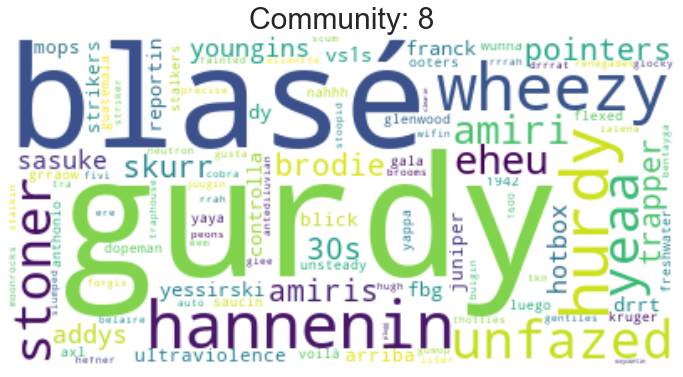

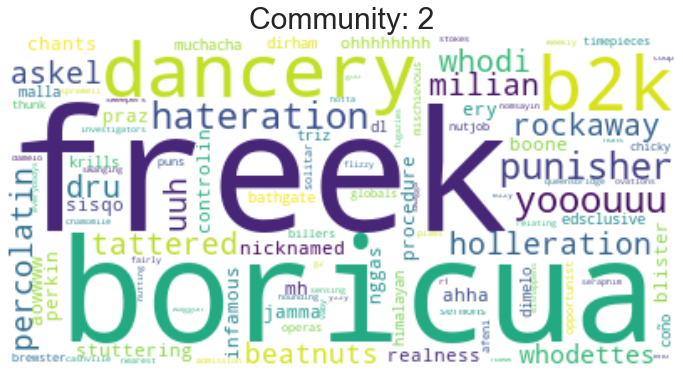

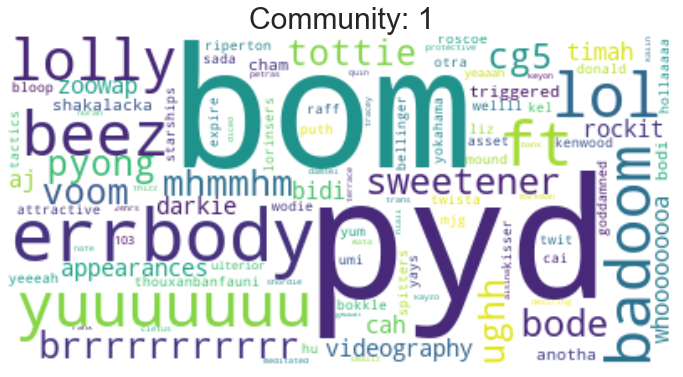

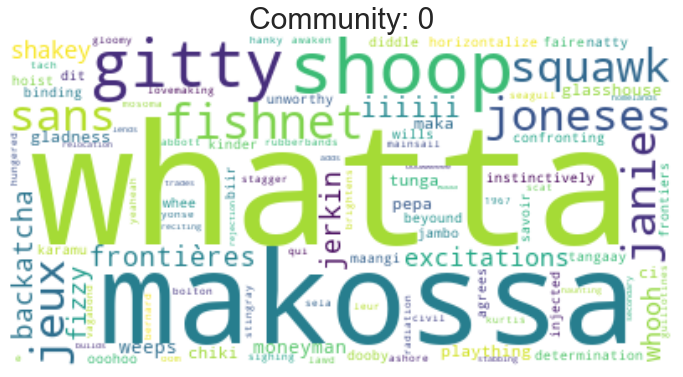

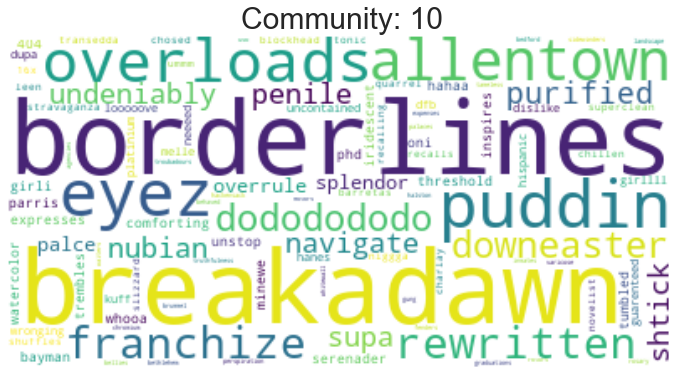

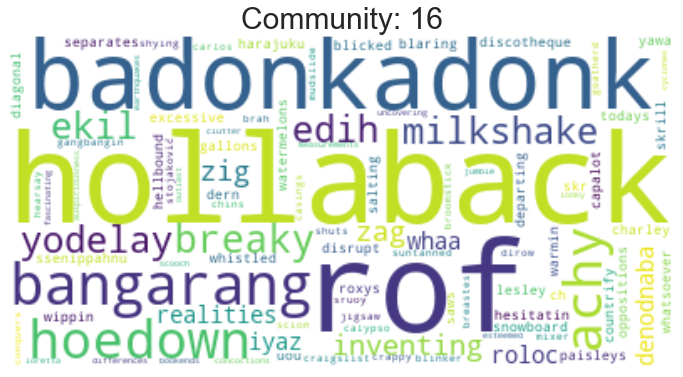

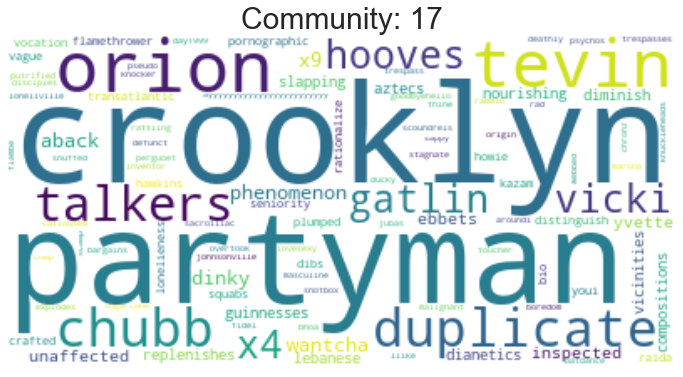

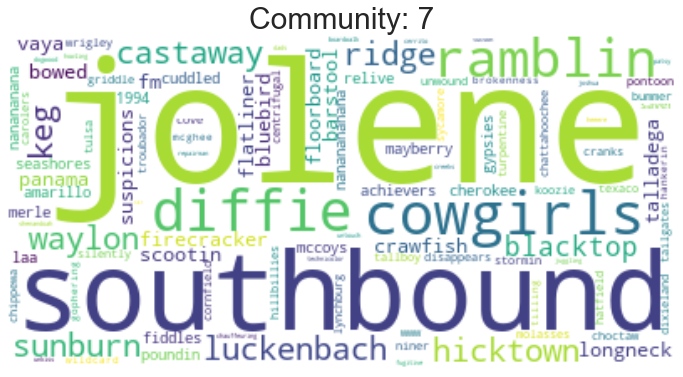

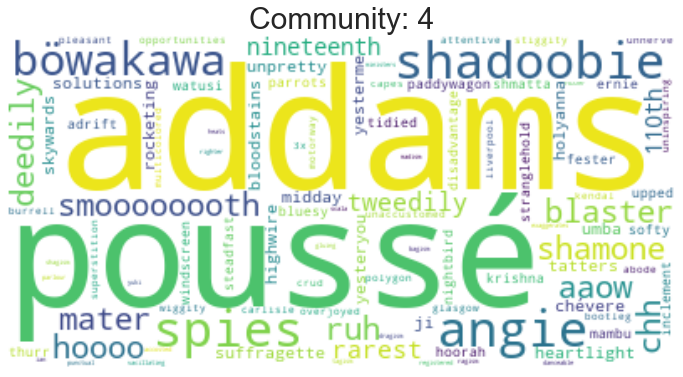

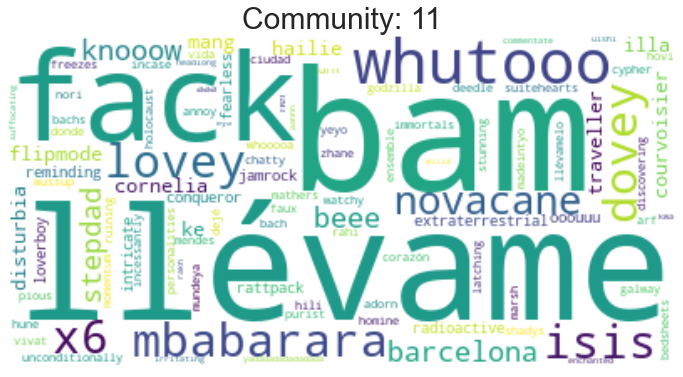

In [584]:
for i in range(0,10):
    generate_wordcloud(tf_idf_list[i], "Community: " + str(n_c[i][0]))

These wordclouds consisting of unique terms might seem rubbish at first. However, by analyzing in relation to found artists within the different communities, they do make some sense!

The first wordcloud for communtiy **8** is filled with different slang. New invented slang is very common among modern rap musicians, which is exactly what this comminy consist of.

The second wordcloud related to community **2** still uses slang, however in a more traditional way. Many words are actual words as well, and seem quite different. It was revealed that this community houses many different music genres, which makes sense in relation to the different use of distinct words.

If we investigate community **4** that withholds some of the biggest artists of all times, with their origin around the 60's, the biggest term "addams" most likely refers to the popular fictional family "The addams family", that ran as television show back in the 60's [17]. "Bowakawa" and "pousse" form a popular song by John Lennon, and "angie" and "shadoobie" are both popular songs by "The Rolling Stones". Let's not forget Michael Jacksons wonder "Smooth Criminal" either.

It is also impossible not to notice the big "Jolene" all over community **7** which must of course refer to Dolly Partons mega hit by the same name. If we check which community she belongs to, it is of course this exact one:

(17) https://en.wikipedia.org/wiki/The_Addams_Family

In [622]:
print("Dolly Parton's community: {}" .format(partition_lcc_un['Dolly Parton']))

Dolly Parton's community: 7


### Sentimental values within communities

If we investigate the average sentimental value within each community (Computation explained in section **Sentimental Analysis**), it is assumed on behalf of the hypothesis for this project, that the values will be lower for communities containing more modern artists, and vica verca. The average sentimental value is calculated by taking the total average of all lyrics related sVal values wihtin a community.

In [691]:
def getSentiment(artist):
    sentiments = []
    # Check if artist contains any songs.
    if bool(G.nodes[artist]):
        for title in G.nodes[artist]['songs'].keys():
            if G.nodes[artist]['songs'][title]['lyrics'] != '404 Error':
                sVal = G.nodes[artist]['songs'][title]['sVal']
                if not math.isnan(sVal):  
                    sentiments.append(sVal)
    return sentiments

commnity_sentiment_average = []
# Calculate all sentiment values for every artists wihtin each community
for i in range(N):
    com_sVal = []
    for artist in commnity_artists[i]:
        artist_sVal = getSentiment(artist)
        if len(artist_sVal) > 0:
            com_sVal += artist_sVal
    # Save average sentiment for entire community
    commnity_sentiment_average.append(sum(com_sVal)/len(com_sVal))

# Print sentimental values
print("Average sentimental value for each community:")
for i in range(N):
    
    print("Community {}: {}".format(n_c[i][0],commnity_sentiment_average[i]))

Average sentimental value for each community:
Community 8: 5.470406543141457
Community 2: 5.621915949337494
Community 1: 5.568893347630396
Community 0: 5.711493101163159
Community 10: 5.683578387804635
Community 16: 5.616226894533104
Community 17: 5.650967735255117
Community 7: 5.660454774574233
Community 4: 5.66140488932631
Community 11: 5.581173629412418


As we investigate the values, it is clear that the communties housing the top modern artists all have lower sentimental values in comparrison to the rest. The numbers doesn't fluctuate too much, however they all represent sentimental values for mainstream music. If the hyphothesis was false, then it would be very unlikely that the exact communities with lowest overall values, all feature the most recent artists.

The biggest community (number **8**) that mostly consisted of rappers has by far the lowest value, ranking in at **5,47**. Community **1**, **11** and **16** follows shortly after with the values **5,57**, **5,58** and **5,62** (rounded). Interestingly, it seems by looking up the top artists within these communities, that rap musician's slowly shrinks. Besides *Justin Bieber*, community **1** almost entirely conists of rappers as well (For the top 10 part nonetheless), whereas community **16** seems to be housing a broad variety of genres, including both rap, pop and edm. Even *Hannah Montana* is part of this community - "Miley Cyrus'" disney child actor character, whom is also represented in real person. The score of this community also gets really close to the rest, which indicates that genre does play some part to the sentimental average - and not just time.

All in all, there does seem to be a clear tendency of more negativity regarding communities of more modern artists, especially the ones who identifies as rappers.

## Sentimental Analysis

For sentimental values we went through all lyrics in the network. We calculated sentimental values through tokenization of the lyrics. The lyrics were tokenized, and stop words were removed. Using the happines_average values from the wordlist from [this link](https://journals.plos.org/plosone/article/file?type=supplementary&id=info:doi/10.1371/journal.pone.0026752.s001), we calculated the average value of every non-stopword token in the lyrics of every song. This value was saved for every song on every artist node.  
Looking at the average sentimental value of songs over time reveals a negative trend in sentimental value. The average sentimental value of the top 100 weekly music hits has decreased over the years, albeit very slightly. The graph is shown zoomed in on the difference, and should only be used to highlight the trend itself, not the magnitude.

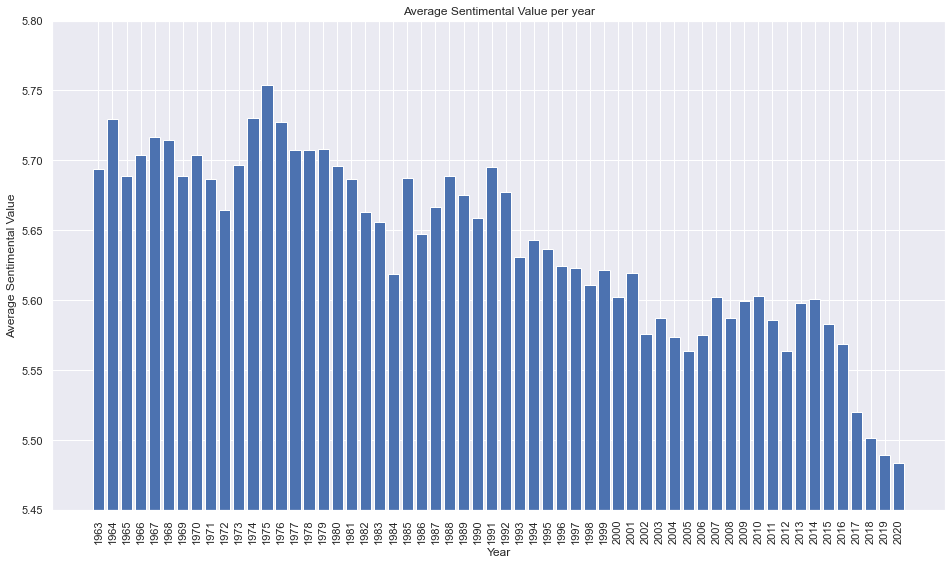

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

figsizew = 16
figsizeh = 9

sentYear = {}
avgSentYear = {}
network = nx.read_gpickle("./fullNetworkSentiment.gpickle")
# Extract every artists song dict. One song dict may contain multiple songs.
songs = [node[1]['songs'] for node in network.nodes(data=True) if 'songs' in node[1]]
for songDict in songs:
    # For every song dict we iterate over every song (key)
    for k in songDict.keys():
        # Get the year from the first placement (earliest)
        year = songDict[k]['placements'][0]['year']
        # Skip this song if there is no sVal (lyrics link was probably not working)
        if 'sVal' not in songDict[k]:
            continue
        sval = songDict[k]['sVal']
        # Skip if sVal is nan (happens if the song is an instrumental)
        if(sval != sval):
            continue
        # Add the sVal to the correct year in the songDict
        if year in sentYear:
            sentYear[year].append(songDict[k]['sVal'])
        else:
            sentYear[year] = [songDict[k]['sVal']]
# Construct the dictionary containing average sVals for all years
avgSentYear = [(k,(sum(v)/len(v))) for k,v in sentYear.items()]
avgSentYear = sorted(avgSentYear)
plt.figure(figsize = (figsizew,figsizeh))
plt.bar([e[0] for e in avgSentYear], [e[1] for e in avgSentYear])
plt.xlabel('Year')
plt.xticks(rotation=90)
plt.ylabel('Average Sentimental Value')
plt.ylim(5.45,5.80)
plt.title('Average Sentimental Value per year')
plt.show()

Next, we looked at the sentimental value averages in intervals independent of year, namely the average sentimental values of the four quarters. As shown in the graph below, these averages are *very* close and it can be concluded that there is no significant difference between quarters in terms of sentimental value.

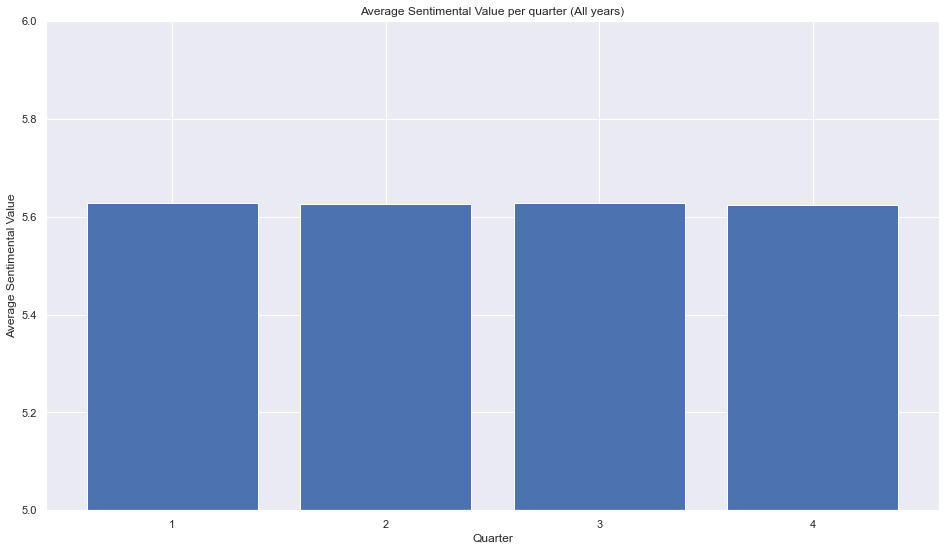

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

figsizew = 16
figsizeh = 9

sentQuarter = {}
avgSentQuarter = {}
network = nx.read_gpickle("./fullNetworkSentiment.gpickle")
songs = [node[1]['songs'] for node in network.nodes(data=True) if 'songs' in node[1]]
# See comments in the block above
for songDict in songs:
    for k in songDict.keys():
        week = int(songDict[k]['placements'][0]['week'])
        quarter = min(4, week// 13 + 1)
        if 'sVal' not in songDict[k]:
            continue
        sval = songDict[k]['sVal']
        if(sval != sval):
            continue
        if quarter in sentQuarter:
            sentQuarter[quarter].append(songDict[k]['sVal'])
        else:
            sentQuarter[quarter] = [songDict[k]['sVal']]
avgSentQuarter = [(k,(sum(v)/len(v))) for k,v in sentQuarter.items()]
avgSentQuarter = sorted(avgSentQuarter)
plt.figure(figsize = (figsizew,figsizeh))
values = [e[1] for e in avgSentQuarter]
plt.bar([e[0] for e in avgSentQuarter], values)
plt.xlabel('Quarter')
plt.xticks(range(1,5,1))
plt.ylabel('Average Sentimental Value')
plt.ylim(5,6)
plt.title('Average Sentimental Value per quarter (All years)')
plt.show()

## Profanity

It feels like a lot of the popular music nowadays uses a lot of profanity, but is this feeling subjective? Or can we observe a general trend?

To explore this, we will in this section look at how big a part profanity is of music though time and which slurs are the most commonly used. 

We use a blacklist as an indicator of which words should be categorized as profanity. The blacklist is created with the help of the swearing dictionary “noswearing” with can be found on [this link](https://www.noswearing.com/dictionary/). We scrape the dictionary for every letter in the alphabet, add to the path, to get a full dictionary of our own. The scraping and formatting is done with the library BeautifulSoup. 


In [1]:
# Open session
session = requests.Session()
blacklist = []

def downloadProfanityList(letter):
    
    # Construct query with leter
    query = "https://www.noswearing.com/dictionary/" + letter
    print(query)
    # Retrieve data
    request = session.get(query)
        
    # Extract html
    html = request.text
    # Parse as beautiful soup
    soup = BeautifulSoup(html, 'html.parser')
    # Get profanity table
    table = soup.find_all('td', valign="top")
    words_raw = table[0].find_all('b')
    
    #Format profanity list
    for word_raw in words_raw:
        wordlist = word_raw.text.split()
        if len(wordlist) > 1:
            word = [' '.join(wordlist)]
        else:
            word = wordlist
        blacklist.append(word[0])
        


In [2]:
letter = 'A'
for i in range(0, 26):
    downloadProfanityList(letter)
    letter = chr(ord(letter) + 1)

https://www.noswearing.com/dictionary/A
https://www.noswearing.com/dictionary/B
https://www.noswearing.com/dictionary/C
https://www.noswearing.com/dictionary/D
https://www.noswearing.com/dictionary/E
https://www.noswearing.com/dictionary/F
https://www.noswearing.com/dictionary/G
https://www.noswearing.com/dictionary/H
https://www.noswearing.com/dictionary/I
https://www.noswearing.com/dictionary/J
https://www.noswearing.com/dictionary/K
https://www.noswearing.com/dictionary/L
https://www.noswearing.com/dictionary/M
https://www.noswearing.com/dictionary/N
https://www.noswearing.com/dictionary/O
https://www.noswearing.com/dictionary/P
https://www.noswearing.com/dictionary/Q
https://www.noswearing.com/dictionary/R
https://www.noswearing.com/dictionary/S
https://www.noswearing.com/dictionary/T
https://www.noswearing.com/dictionary/U
https://www.noswearing.com/dictionary/V
https://www.noswearing.com/dictionary/W
https://www.noswearing.com/dictionary/X
https://www.noswearing.com/dictionary/Y


The blacklist then contains the words seen below.

In [4]:
blacklist

['anus',
 'arse',
 'arsehole',
 'ass',
 'ass-hat',
 'ass-jabber',
 'ass-pirate',
 'assbag',
 'assbandit',
 'assbanger',
 'assbite',
 'assclown',
 'asscock',
 'asscracker',
 'asses',
 'assface',
 'assfuck',
 'assfucker',
 'assgoblin',
 'asshat',
 'asshead',
 'asshole',
 'asshopper',
 'assjacker',
 'asslick',
 'asslicker',
 'assmonkey',
 'assmunch',
 'assmuncher',
 'assnigger',
 'asspirate',
 'assshit',
 'assshole',
 'asssucker',
 'asswad',
 'asswipe',
 'axwound',
 'bampot',
 'bastard',
 'beaner',
 'bitch',
 'bitchass',
 'bitches',
 'bitchtits',
 'bitchy',
 'blow job',
 'blowjob',
 'bollocks',
 'bollox',
 'boner',
 'brotherfucker',
 'bullshit',
 'bumblefuck',
 'butt plug',
 'butt-pirate',
 'buttfucka',
 'buttfucker',
 'camel toe',
 'carpetmuncher',
 'chesticle',
 'chinc',
 'chink',
 'choad',
 'chode',
 'clit',
 'clitface',
 'clitfuck',
 'clusterfuck',
 'cock',
 'cockass',
 'cockbite',
 'cockburger',
 'cockface',
 'cockfucker',
 'cockhead',
 'cockjockey',
 'cockknoker',
 'cockmaster',
 'c

To get an idea of how much profanity and specifically which words are used in a song lyrics, we define the function *countProfanity*. This function takes a song lyric, tokenize it and checks whether a token matches any word in the blacklist. For every matched word the dictionary *count_dict* is updated with the word as key and the number of matches as the value. The function returns both the dictionary and the length of the token list as an indicator of how many words the song has in total.

In [7]:
def tokenize(lyrics):
    #Get tokens
    tokens = nltk.word_tokenize(lyrics)
    #Remove stopwords
    tokens = [token for token in tokens if token not in stopwords]
    #Checks type
    tokens = [token for token in tokens if token.isalnum()]
    #Tokens to lower
    tokens = [token.lower() for token in tokens]
    return tokens


def countProfanity(lyrics):
    count_dict = {}
    #lyrics to tokens
    tokens = tokenize(lyrics)
    for token in tokens:
        #Check if token is in blacklist
        if token in blacklist:
            #Add to or create entry in count_dict
            if token in count_dict.keys():
                count_dict[token] += 1
            else:
                count_dict[token] = 1
    return count_dict, len(tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\betta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\betta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Having the blacklist and the *countProfanity* function, we go through the entire network and stores for every song the profanity count map and the total count of words in the lyrics. 

In [99]:
for node in network.nodes(data=True):
    i = i + 1
    if 'songs' in node[1]:
        for k, v in node[1]['songs'].items():
            #If there is a lyric
            if(not v['lyrics'] == "404 Error"):
                #Get profanity and count of words in total
                v['profanity'], v['lyricsLenght'] = countProfanity(v['lyrics'])

Going though the updated network we then calculate how many times a word was used and the total count of words in lyrics. 

In [100]:
yearlyLyricsCount = {}
yearlyProfanityDict = {}

def addDicts(year, dictionary):
    #For every word in dictionary
    for k,v in dictionary.items():
        #Check if word in yearlyProfanityDict
        if k in yearlyProfanityDict[year].keys():
            #Add to existing
            yearlyProfanityDict[year][k] += v
        else:
            #Create entry
            yearlyProfanityDict[year][k] = v

for node in network.nodes(data=True):
    if 'songs' in node[1]:
        for k, v in node[1]['songs'].items():
            year = int(v['placements'][0]['year'])
            if 'profanity' in v.keys():
                #Check if year in yearlyProfanityDict
                if year in yearlyProfanityDict.keys():
                    #Count lyrics
                    yearlyLyricsCount[year] += v['lyricsLenght']
                    #Add to existing
                    addDicts(year, v['profanity'])
                else:
                    #Count lyrics
                    yearlyLyricsCount[year] = v['lyricsLenght']
                    #Create entry
                    yearlyProfanityDict[year] = v['profanity']
            elif not v['lyrics'] == "404 Error":
                #Check if year in yearlyLyricsCount
                if year in yearlyLyricsCount:
                    #Count lyrics
                    yearlyLyricsCount[year] += v['lyricsLenght']
                else:
                    #Count lyrics
                    yearlyLyricsCount[year] = v['lyricsLenght']


Having the *yearlyProfanityDict* we count the amount of times profanity was used in a year with the function *countDict*.

In [10]:
yearlyProfanityCount = {}

def countDict(dictionary):
    count = 0
    for k, v in dictionary.items():
        count = count + v
    return count 
                    
for k,v in yearlyProfanityDict.items():
    yearlyProfanityCount[k] = countDict(v)


With the values in *yearlyProfanityCount* and *yearlyLyricsCount* we calculate a profanity frequency for every year, and plot them as seen in the figure below.

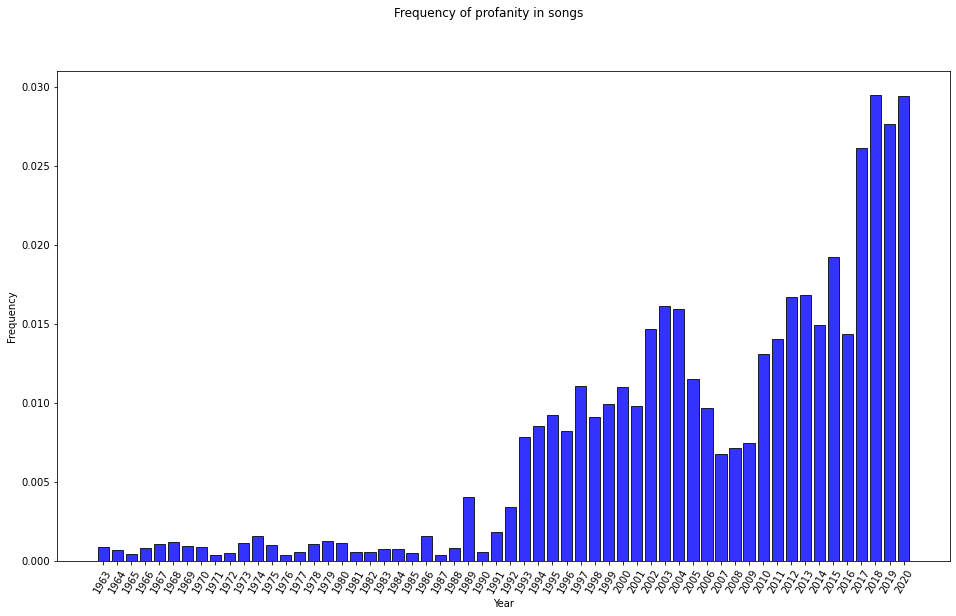

In [11]:
yearlyFrequency = {}

for k,v in yearlyProfanityCount.items():
    yearlyFrequency[k] = yearlyProfanityCount[k]/yearlyLyricsCount[k]


plt.figure(figsize=(16,9))
plt.bar(list(yearlyFrequency.keys()), yearlyFrequency.values(), alpha=0.8, color='blue',
         ec='black')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.suptitle('Frequency of profanity in songs')
plt.xticks(np.arange(1963, 2021, step=1), rotation=60)
plt.show()

By looking in the graph it is clear to see that the amount of profanity used in music has been steadily rising, but interestingly enough we see substantially dip in the years from 2005 to 2009, could the financial crises have anything to do with this?

Now we know that the general use of profanity is increasing, but can we get a sense of what words are primarily used in music, and has there been a shift? 

By looking through the dictionary *yearlyProfanityDict* we get the most commonly used swear words based on year, the list can be seen below.

In [12]:
import collections
mostPopularProfanity = []
print('Most used profanity in the years:')
od = collections.OrderedDict(sorted(yearlyProfanityDict.items()))
for k, v in od.items():
    word = max(v, key=v.get)
    print(str(k) + ': ' + word)
    #Save all the most populær swear words
    if word not in mostPopularProfanity:
        mostPopularProfanity.append(word)

Most used profanity in the years:
1963: hell
1964: hell
1965: gay
1966: hell
1967: hell
1968: hell
1969: negro
1970: hell
1971: hell
1972: hell
1973: hell
1974: bitch
1975: hell
1976: hell
1977: damn
1978: negro
1979: hell
1980: hell
1981: hell
1982: wop
1983: hell
1984: negro
1985: hell
1986: dick
1987: hell
1988: hell
1989: fuck
1990: hell
1991: fuck
1992: ass
1993: shit
1994: shit
1995: shit
1996: nigga
1997: nigga
1998: shit
1999: nigga
2000: nigga
2001: shit
2002: shit
2003: nigga
2004: shit
2005: nigga
2006: shit
2007: damn
2008: nigga
2009: shit
2010: fuck
2011: bitch
2012: bitch
2013: nigga
2014: nigga
2015: nigga
2016: nigga
2017: nigga
2018: bitch
2019: nigga
2020: bitch


We create the map popularProfanityCount which contains individual swear words count for every year.

In [13]:
popularProfanityCount = {}
for k, v in yearlyProfanityDict.items():
    #Create count map
    count = {}
    for word in mostPopularProfanity:
        #Check if word in count map
        if word in v.keys():
            count[word] = v[word]
        else:
            count[word] = 0
    #Save count map with year as key
    popularProfanityCount[k] = count

We calculate the term frequency based on the values from *popularProfanityCount* and *yearlyLyricsCount*, and plot them as seen in the figure below.

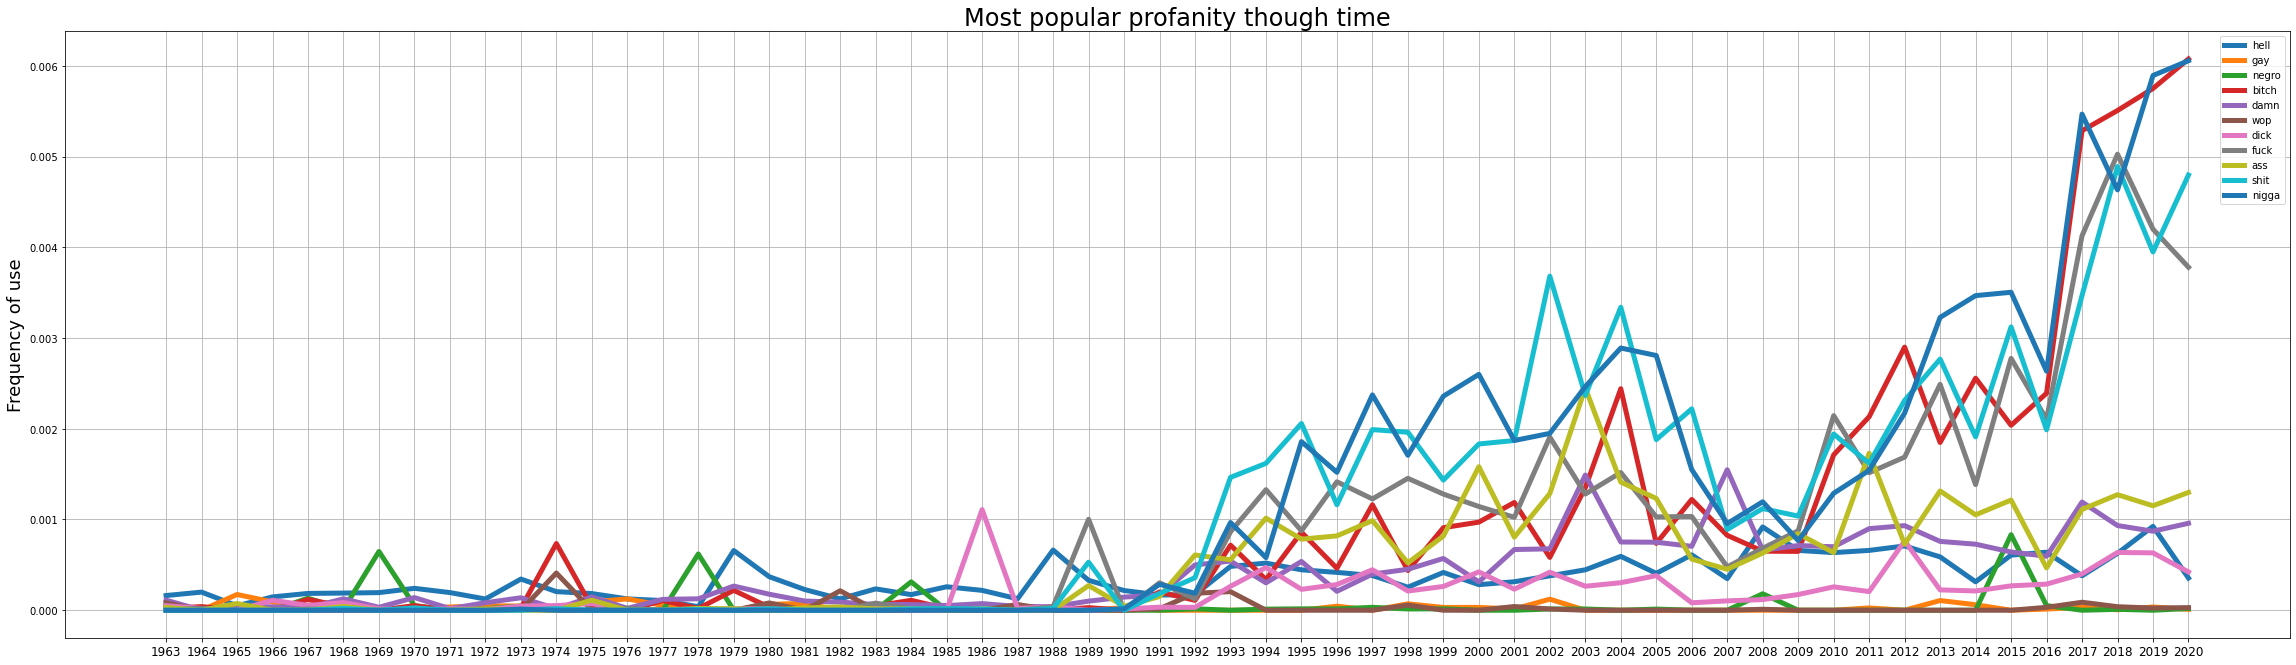

In [17]:
yearlyPopularFrequency = {}

for k,v in popularProfanityCount.items():
    wordFrequencies = {}
    #Calculate frequency for every count in popularProfanityCount
    for word, count in v.items():
        #Create entry with word as key
        wordFrequencies[word] = count/yearlyLyricsCount[k]
    #Create entry with year as key
    yearlyPopularFrequency[k] = wordFrequencies

fig, ax = plt.subplots()

od = collections.OrderedDict(sorted(yearlyPopularFrequency.items()))

for word in mostPopularProfanity:
    ax.plot(list(od.keys()),[
        od[i][word] for i in range(1963, 2021)
    ], label=word, linewidth=5)

ax.set_ylabel("Frequency of use", size=18)
ax.legend(loc="upper right")
plt.xticks(np.arange(1963, 2021, step=1), size=12)
fig.set_size_inches(32,9)
fig.tight_layout()
plt.title("Most popular profanity though time", size=24)
ax.grid()
plt.show()

What we can observe through the graph is again a general increase in frequency for profanity, but in addition to that we see a shift in which words are used in different periods. We have that profanity such as *hell* and *negro* was the goto in the time from 1968 to 1980, and words such as *nigga* and *bitch* is the most frequent now. 

# Discussion

This project aimed to find out whether or not music has become more negatively charged over time in regard to popular releases. This was investigated by looking at both the overall trend and in specific communities of artists/genres. As the data sets applied to generate the network all covered popular music, popularity itself was investigated by different metrics as well to get a better grasp of what exactly we were working with.

There were some shortcomings regarding data collections. In part, we could have collected more data from the Genius API, namely the song ID, to further distinguish between unique songs when analysing the network. On the other hand, there were often times where the Genius API would give us data unsuited for our project, such as entire manuscripts or books. 
There were also inconsistencies in how primary artists were handled. Oftentimes, instead of listing multiple primary artists as a list of artists, the primary artists would be listed as a single artist containing both names. This required us to account for this situation by splitting primary artist names via regular expressions, which would infrequently lead to wrong splits. An example of a wrong split is “Earth, Wind & Fire”, which would be split in two as “Earth, Wind” & “Fire”.

The data scraping from Billboard’s website wasn’t perfect either, as the date format used to query html content changed multiple times over the first few years represented on the charts, with no clear pattern or reasoning to why. This ultimately led to the deletion of the first 5 years of the dataset, as more corrupted data kept showing up.

The investigation of sentimental values both within and outside specific communities turned out to represent a tendency in accordance with the hypothesis. The general goals of the project were therefore fulfilled.


To investigate upon these goals even further, a profanity analysis was deducted as well, to try and look at the “problem” from a different angle, with another measure of negativity. As Christas time is upon us, generally referred to as the happiest time a year, we sought out to investigate if the average decreasing trend also applied to the popular holiday.

The profanity analysis showcased an increase in the use of swear words, some much more than others. Generally speaking, the analysis did support the hypothesis regarding music becoming more negatively charged, just like the sentimental analysis.

In the analysis of Christmas releases it was revealed that the average sentiment was generally higher than what was expected of an ordinary song, which only supported our assumption that it really is the happiest time of the year.  To further investigate the average sentimental value of Christmas songs though time, we would have needed to gather the songs from another source specifically made for this, since only a few of them actually become popular enough to make it on the Billboard hot 100 chart. 

## Conclusion

It can be concluded from our network analysis, that music lyrics have grown more negative over time. Our analysis shows an undeniable decline in the average sentimental value of the top 100 weekly song lyrics over the years.  
From our community analysis, it is also seen that more recent communities have an overall lower average sentimental value than communities from many years back. The communities also appear to align with our understanding of genres, with each community showing a clear majority within one or two genres each.

# Contributions

Generally speaking, every member of the group worked or at least helped out on almost every part of the assignment. However, some group members were more in charge than others of different parts regarding both this and project assignment A.

Regarding representational work Betta was in charge of the video creation, Mikkel was in charge of the notebook structure and Sebastian was in charge of the website development.

Regarding the created network, all members contributed equally to define goals for the project, find relevant information and proper sources of data, as well as planning out features and analytical parts of the project. For the actual retrieval of the datasets, Mikkel was in charge of handling the Billboard data and Sebastian was in charge of the data from Genius and final creation of the Network.

For the actual content of the report regarding section 2 and 3, Mikkel was in charge of the Basic stats and visualization of the network, both Sebastian and Mikkel was in charge of connectedness, both Betta and Mikkel was in charge of Most Popular, Mikkel was in charge of communities, Sebastian was in charge of sentimental values and Betta was in charge of profanity.